# **Proyek Analisis Sentimen Aplikasi "Qara'a - Belajar Ngaji Quran"**

### BAGIAN 0: SETUP DAN IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
import os
import requests
from io import StringIO
import csv

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Sastrawi (Stemming Bahasa Indonesia)
%pip install sastrawi -q
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory # Alternatif stopword remover

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB # Baik untuk teks & TF-IDF
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# WordCloud
from wordcloud import WordCloud

# Mengatur seed untuk reproduktifitas
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Opsi Pandas
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 200)

print("Semua library berhasil diimport.")
print(f"Versi TensorFlow: {tf.__version__}")

Note: you may need to restart the kernel to use updated packages.
Semua library berhasil diimport.
Versi TensorFlow: 2.16.1


-   **Metode yang digunakan:**
    * Penggunaan perintah `import` dan `from ... import ...` untuk memuat berbagai pustaka (libraries) Python yang diperlukan untuk proyek analisis sentimen.
    * Instalasi pustaka Sastrawi secara dinamis menggunakan `%pip install sastrawi -q` (khusus untuk lingkungan seperti Jupyter Notebook/Colab).
    * Pengunduhan paket `punkt` (untuk tokenisasi) dan `stopwords` dari NLTK menggunakan `nltk.download()`.
    * Pengaturan *seed* untuk `numpy` dan `tensorflow` guna memastikan reproduktibilitas hasil.
    * Konfigurasi opsi Pandas untuk tampilan (`max_colwidth`) dan penanganan `ChainedAssignmentWarning`.

-   **Alasan penggunaan:**
    * **Modularitas dan Efisiensi:** Mengimpor pustaka memungkinkan penggunaan fungsi-fungsi yang sudah ada dan teruji, sehingga tidak perlu menulis kode dari awal untuk setiap tugas. Ini menghemat waktu dan mengurangi potensi kesalahan.
    * **Kebutuhan Fungsional Proyek:**
        * `pandas` dan `numpy`: Untuk manipulasi data tabular (DataFrame), operasi numerik, dan struktur data array.
        * `matplotlib` dan `seaborn`: Untuk visualisasi data dan hasil analisis.
        * `re`, `string`, `nltk`, `Sastrawi`: Untuk berbagai tahapan pemrosesan awal teks (preprocessing) seperti membersihkan teks dari karakter tidak penting, tokenisasi, penghapusan stopwords, dan stemming khusus untuk Bahasa Indonesia.
        * `scikit-learn`: Menyediakan alat untuk ekstraksi fitur (seperti `TfidfVectorizer`), pembagian dataset, implementasi algoritma machine learning klasik (MultinomialNB, SVC, LogisticRegression, RandomForestClassifier), evaluasi model (metrik akurasi, classification report, confusion matrix), dan optimasi hyperparameter (GridSearchCV).
        * `tensorflow.keras`: Digunakan untuk membangun, melatih, dan mengevaluasi model deep learning. Menyediakan layer-layer penting seperti `Embedding` (untuk representasi kata), `LSTM` & `Bidirectional` (untuk menangkap dependensi sekuensial), `Conv1D` (untuk fitur lokal), `Dense` (fully connected layer), serta utilitas untuk tokenisasi dan padding sekuens khusus Keras. Juga menyediakan *callbacks* seperti `EarlyStopping` dan `ReduceLROnPlateau` untuk optimasi proses pelatihan.
        * `wordcloud`: Untuk membuat visualisasi awan kata yang intuitif dari data teks.
        * `requests`, `io.StringIO`, `csv`: Berguna untuk mengambil data dari sumber online (misalnya, file CSV dari URL) dan memprosesnya.
        * `time`, `os`: Untuk operasi terkait waktu (misalnya mengukur durasi pelatihan) dan interaksi dengan sistem operasi.
    * **Reproduktibilitas:** Pengaturan *seed* pada `numpy` dan `tensorflow` sangat penting agar hasil eksperimen (misalnya inisialisasi bobot model, pembagian data acak) dapat diulang secara konsisten, memudahkan debugging dan perbandingan antar model.
    * **Kenyamanan Pengembangan:** Pengaturan opsi Pandas seperti `max_colwidth` membantu dalam menampilkan isi teks yang panjang pada DataFrame secara lebih utuh selama analisis.

-   **Insight dan Hasil yang didapat:**
    * **Lingkungan Siap:** Kode ini berhasil menyiapkan lingkungan Python dengan semua pustaka dan dependensi yang diperlukan untuk menjalankan proyek analisis sentimen secara menyeluruh, mulai dari pengumpulan data (jika diperlukan), pemrosesan teks, pelatihan model (baik machine learning klasik maupun deep learning), evaluasi, hingga visualisasi.
    * **Konfirmasi Versi:** Output `Versi TensorFlow: 2.16.1` mengonfirmasi bahwa TensorFlow telah berhasil diimpor dan versi yang digunakan adalah 2.16.1. Ini penting untuk memastikan kompatibilitas kode dan fitur yang digunakan.
    * **Instalasi Sastrawi:** Pesan `Note: you may need to restart the kernel to use updated packages.` muncul setelah instalasi Sastrawi, yang merupakan pemberitahuan standar. Dalam banyak kasus, kernel tidak perlu di-restart jika impor dilakukan setelah sel instalasi.

### BAGIAN 1: MEMUAT DATASET

In [2]:
print("--- BAGIAN 1: MEMUAT DATASET ---")
# Pastikan file qaraa_reviews_scraped.csv ada di folder dataset_scraped/
data_path = 'dataset_scraped/qaraa_reviews_scraped.csv'

try:
    df_raw = pd.read_csv(data_path)
    print(f"Dataset berhasil dimuat: {data_path}")
    print(f"Jumlah baris awal: {len(df_raw)}")
    print(f"Jumlah kolom awal: {len(df_raw.columns)}")
    print("Informasi dataset awal:")
    df_raw.info()
    print("\nContoh data awal:")
    print(df_raw.head())
except FileNotFoundError:
    print(f"ERROR: File dataset tidak ditemukan di {data_path}")
    print("Pastikan Anda sudah menjalankan notebook scraping (1_scraping_reviews.ipynb) dan file CSV sudah ada.")
    df_raw = pd.DataFrame() # Buat dataframe kosong agar notebook bisa jalan sebagian

# Hanya gunakan kolom yang relevan, terutama 'content' untuk teks ulasan dan 'score' untuk pelabelan awal jika ada
if not df_raw.empty:
    df = df_raw[['content', 'score']].copy() # 'score' mungkin digunakan untuk validasi lexicon atau pelabelan awal
    print("\nDataset setelah memilih kolom 'content' dan 'score':")
    print(df.head())
else:
    df = pd.DataFrame({'content': [], 'score': []})

--- BAGIAN 1: MEMUAT DATASET ---
Dataset berhasil dimuat: dataset_scraped/qaraa_reviews_scraped.csv
Jumlah baris awal: 11366
Jumlah kolom awal: 11
Informasi dataset awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11366 entries, 0 to 11365
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              11366 non-null  object
 1   userName              11366 non-null  object
 2   userImage             11366 non-null  object
 3   content               11366 non-null  object
 4   score                 11366 non-null  int64 
 5   thumbsUpCount         11366 non-null  int64 
 6   reviewCreatedVersion  9504 non-null   object
 7   at                    11366 non-null  object
 8   replyContent          8198 non-null   object
 9   repliedAt             8198 non-null   object
 10  appVersion            9504 non-null   object
dtypes: int64(2), object(9)
memory usage: 976.9+ KB

Contoh data awal:

-   **Metode yang digunakan:**
    * `pd.read_csv(data_path)`: Fungsi dari pustaka Pandas yang digunakan untuk membaca data dari file berformat CSV (Comma Separated Values) yang disimpan pada `data_path` dan mengubahnya menjadi struktur data DataFrame bernama `df_raw`.
    * Blok `try-except FileNotFoundError`: Struktur penanganan error untuk mengantisipasi jika file dataset tidak ditemukan pada path yang telah ditentukan. Jika file tidak ada, akan dicetak pesan kesalahan dan dibuat DataFrame kosong (`df_raw = pd.DataFrame()`) agar sisa kode dalam notebook masih bisa dijalankan tanpa error fatal.
    * `len(df_raw)` dan `len(df_raw.columns)`: Fungsi dan atribut untuk mendapatkan jumlah baris dan jumlah kolom dari DataFrame.
    * `df_raw.info()`: Metode DataFrame untuk menampilkan ringkasan informasi tentang DataFrame `df_raw`, meliputi jumlah total entri (baris), jumlah kolom, nama setiap kolom, jumlah nilai non-null (tidak kosong) per kolom, dan tipe data (Dtype) dari setiap kolom.
    * `df_raw.head()`: Metode DataFrame untuk menampilkan beberapa baris pertama (defaultnya 5 baris) dari `df_raw`, memberikan gambaran awal mengenai isi data.
    * `df_raw[['content', 'score']].copy()`: Operasi untuk memilih kolom spesifik yaitu 'content' (yang berisi teks ulasan) dan 'score' (rating yang diberikan pengguna) dari `df_raw` dan membuat salinan independennya ke dalam DataFrame baru bernama `df`. Penggunaan `.copy()` penting untuk menghindari masalah `SettingWithCopyWarning` dan memastikan bahwa `df` adalah objek baru, bukan hanya *view* dari `df_raw`.

-   **Alasan penggunaan:**
    * `pd.read_csv` adalah metode standar dan paling umum dalam ekosistem Python untuk mengimpor data dari file CSV, format yang sering digunakan untuk menyimpan data tabular hasil scraping atau ekspor dari database.
    * Penanganan `FileNotFoundError` penting untuk membuat notebook lebih *robust* dan memberikan umpan balik yang jelas kepada pengguna jika prasyarat (ketersediaan file data) tidak terpenuhi, misalnya jika skrip scraping belum dijalankan.
    * `len()`, `.info()`, dan `.head()` merupakan langkah fundamental dalam *Exploratory Data Analysis (EDA)* awal. Mereka memberikan pemahaman cepat mengenai ukuran dataset, kelengkapan data (adanya nilai null), tipe data yang mungkin memerlukan konversi, dan sampel aktual dari data untuk verifikasi dan pemahaman konteks.
    * Pemilihan kolom `content` dan `score` dilakukan untuk memfokuskan analisis pada data yang paling relevan untuk tugas analisis sentimen. Kolom `content` adalah input utama (teks ulasan), sedangkan `score` seringkali digunakan sebagai dasar untuk pelabelan sentimen (misalnya, skor 1-2 negatif, 3 netral, 4-5 positif) atau untuk validasi hasil pelabelan otomatis. Mengurangi jumlah kolom juga dapat meningkatkan efisiensi pemrosesan di tahap selanjutnya.

-   **Insight dan Hasil yang didapat:**
    * **Keberhasilan Pemuatan Data:** Dataset dari file `dataset_scraped/qaraa_reviews_scraped.csv` berhasil dimuat ke dalam DataFrame `df_raw`.
    * **Ukuran Dataset Awal:** Dataset awal terdiri dari **11.366 baris** (yang berarti ada 11.366 ulasan) dan **11 kolom**.
    * **Informasi Kolom dan Tipe Data:**
        * Dari output `df_raw.info()`, diketahui bahwa kolom-kolom seperti `reviewId`, `userName`, `userImage`, `content`, `score`, `thumbsUpCount`, dan `at` tidak memiliki nilai null, yang menandakan kelengkapan data pada kolom-kolom tersebut.
        * Kolom `reviewCreatedVersion`, `replyContent`, `repliedAt`, dan `appVersion` memiliki beberapa nilai null. Ini wajar, karena tidak semua ulasan mungkin memiliki informasi versi aplikasi saat ulasan dibuat, atau tidak semua ulasan mendapatkan balasan dari pengembang.
        * Tipe data `score` dan `thumbsUpCount` adalah `int64` (numerik), sedangkan sisanya mayoritas adalah `object` (biasanya menandakan string).
    * **Contoh Data:** `df_raw.head()` memperlihatkan sampel 5 baris pertama data, memberikan gambaran nyata tentang isi setiap kolom, termasuk teks ulasan yang beragam panjangnya dan informasi metadata lainnya.
    * **Pemilihan Kolom Relevan:** DataFrame baru `df` berhasil dibuat, yang hanya berisi kolom `content` dan `score`. DataFrame ini memiliki jumlah baris yang sama dengan `df_raw` (11.366 baris) tetapi hanya 2 kolom. Ini menyiapkan data untuk tahap pemrosesan selanjutnya dengan lebih fokus.

### BAGIAN 2: EKSPLORASI DATA AWAL (EDA) & DATA CLEANING

--- BAGIAN 2: EDA & DATA CLEANING ---

Missing values per kolom:
content    0
score      0
dtype: int64
Jumlah baris setelah menghapus content kosong: 11366
Jumlah ulasan duplikat (berdasarkan 'content'): 2649
Jumlah baris setelah menghapus duplikat: 8717


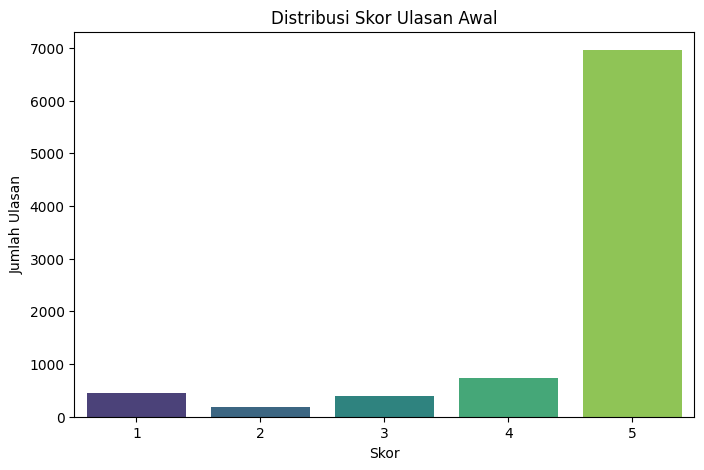

In [3]:
print("--- BAGIAN 2: EDA & DATA CLEANING ---")
# Cek missing values
print("\nMissing values per kolom:")
print(df.isnull().sum())

# Hapus baris dengan 'content' yang kosong (jika ada)
df.dropna(subset=['content'], inplace=True)
df = df[df['content'].str.strip() != ''] # Hapus jika content hanya spasi
print(f"Jumlah baris setelah menghapus content kosong: {len(df)}")

# Cek duplikasi ulasan
print(f"Jumlah ulasan duplikat (berdasarkan 'content'): {df.duplicated(subset=['content']).sum()}")
df.drop_duplicates(subset=['content'], keep='first', inplace=True)
print(f"Jumlah baris setelah menghapus duplikat: {len(df)}")

# Distribusi 'score' (jika akan digunakan)
if 'score' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x='score', data=df, palette='viridis')
    plt.title('Distribusi Skor Ulasan Awal')
    plt.xlabel('Skor')
    plt.ylabel('Jumlah Ulasan')
    plt.show()

-   **Metode yang digunakan:**
    * `df.isnull().sum()`: Metode Pandas untuk menghitung jumlah nilai yang hilang (missing values/NaN) pada setiap kolom dalam DataFrame `df`.
    * `df.dropna(subset=['content'], inplace=True)`: Metode untuk menghapus baris-baris yang memiliki nilai kosong (NaN) pada kolom 'content'. Argumen `inplace=True` memodifikasi DataFrame `df` secara langsung.
    * `df[df['content'].str.strip() != '']`: Seleksi baris untuk memfilter dan mempertahankan hanya baris di mana kolom 'content' setelah dihilangkan spasi di awal dan akhir (`str.strip()`) tidak kosong. Ini efektif menghapus ulasan yang hanya berisi spasi.
    * `df.duplicated(subset=['content']).sum()`: Menghitung jumlah baris yang merupakan duplikat berdasarkan isi dari kolom 'content'.
    * `df.drop_duplicates(subset=['content'], keep='first', inplace=True)`: Menghapus baris-baris duplikat berdasarkan kolom 'content', dengan mempertahankan kemunculan pertama (`keep='first'`) dan memodifikasi DataFrame `df` secara langsung.
    * `sns.countplot(x='score', data=df, palette='viridis')`: Fungsi dari pustaka Seaborn untuk membuat plot batang (bar plot) yang menunjukkan frekuensi atau jumlah kemunculan setiap nilai unik dalam kolom 'score'.
    * `plt.title()`, `plt.xlabel()`, `plt.ylabel()`, `plt.show()`: Fungsi-fungsi dari Matplotlib untuk menambahkan judul, label sumbu x dan y, serta menampilkan plot.

-   **Alasan penggunaan:**
    * **Pengecekan Missing Values:** Penting untuk mengetahui apakah ada data yang hilang, terutama pada kolom 'content' yang menjadi input utama analisis. Data yang hilang dapat menyebabkan error atau hasil analisis yang tidak akurat.
    * **Penghapusan Konten Kosong/Spasi:** Ulasan yang kosong atau hanya berisi spasi tidak memberikan informasi sentimen dan dapat dianggap sebagai noise. Menghapusnya akan membersihkan dataset.
    * **Penghapusan Duplikat:** Ulasan yang sama persis (duplikat) dapat membiaskan hasil analisis, misalnya dengan memberikan bobot lebih pada sentimen tertentu secara tidak adil. Menghapus duplikat memastikan setiap ulasan unik dipertimbangkan hanya sekali. `keep='first'` adalah strategi standar untuk mempertahankan salah satu instance duplikat.
    * **Visualisasi Distribusi Skor:** Memahami distribusi skor ulasan (misalnya, rating bintang 1 hingga 5) memberikan gambaran awal mengenai sentimen umum pengguna terhadap produk/layanan. Ini juga penting jika skor akan digunakan sebagai dasar untuk pelabelan sentimen (positif, negatif, netral). Visualisasi membantu mengidentifikasi apakah ada ketidakseimbangan kelas yang signifikan.

-   **Insight dan Hasil yang didapat:**
    * **Missing Values:** Output `Missing values per kolom:` menunjukkan `content 0` dan `score 0`. Ini berarti pada DataFrame `df` (yang sudah dipilih hanya kolom 'content' dan 'score'), tidak ditemukan nilai null pada kedua kolom tersebut sebelum proses penghapusan eksplisit.
    * **Penghapusan Konten Kosong:** `Jumlah baris setelah menghapus content kosong: 11366`. Karena tidak ada nilai null pada 'content', jumlah baris tetap sama setelah langkah `dropna`. Langkah `df[df['content'].str.strip() != '']` juga tidak mengubah jumlah baris, menandakan tidak ada ulasan yang hanya berisi spasi.
    * **Penghapusan Duplikat:**
        * `Jumlah ulasan duplikat (berdasarkan 'content'): 2649`. Ditemukan sejumlah 2649 ulasan yang memiliki teks konten yang sama persis.
        * `Jumlah baris setelah menghapus duplikat: 8717`. Setelah menghapus duplikat tersebut, jumlah ulasan unik yang tersisa adalah 8717. Ini merupakan langkah pembersihan yang signifikan.
    * **Distribusi Skor Ulasan Awal:**
        * Plot menunjukkan distribusi jumlah ulasan untuk setiap skor dari 1 hingga 5.
        * **Skor 5 (Sangat Positif):** Memiliki jumlah ulasan paling tinggi, mengindikasikan bahwa mayoritas pengguna yang memberikan ulasan merasa sangat puas dengan aplikasi tersebut.
        * **Skor 4 (Positif):** Memiliki jumlah ulasan kedua tertinggi. Ini menunjukkan bahwa ada juga sejumlah besar pengguna yang memberikan respon positif, meskipun tidak setinggi skor 5.
        * **Skor 1 (Sangat Negatif):** Merupakan kategori dengan jumlah ulasan ketiga tertinggi. Meskipun tidak sebanyak skor 5 atau 4, keberadaan ulasan dengan skor 1 ini cukup signifikan dan menandakan adanya area ketidakpuasan yang perlu perhatian.
        * **Skor 3 (Netral):** Jumlah ulasannya berada di urutan keempat.
        * **Skor 2 (Negatif):** Memiliki jumlah ulasan paling sedikit dibandingkan skor lainnya.
        * Distribusi skor menunjukkan kecenderungan kuat ke arah sentimen positif (didominasi oleh skor 5 dan 4). Namun, adanya jumlah ulasan skor 1 yang cukup signifikan juga penting untuk diperhatikan sebagai indikasi adanya masalah atau aspek yang dikeluhkan oleh sebagian pengguna. Terdapat ketidakseimbangan kelas, di mana ulasan positif jauh lebih banyak daripada ulasan netral atau negatif (selain skor 1 yang cukup menonjol).

### BAGIAN 3: TEXT PREPROCESSING

In [4]:
# 3.1. Fungsi-fungsi Preprocessing
def cleaning_text(text):
    text = str(text).lower() # Case folding awal
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Hapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', ' ', text) # Hapus hashtag
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text) # Hapus URL
    text = re.sub(r'\d+', ' ', text) # Hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih
    # Hapus karakter non-alfabet
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Kamus slang
slang_dict_local_path = 'lexicons/combined_slang_words.txt'
slang_dict = {}
try:
    with open(slang_dict_local_path, 'r', encoding='utf-8') as f:
        slang_lines = f.readlines() # Baca semua baris
           
    parsed_count = 0
    for line in slang_lines:
        if line.strip(): # Pastikan baris tidak kosong setelah di-strip
            parts = line.split(':', 1) # Split hanya pada colon pertama, jaga-jaga jika value mengandung colon
            if len(parts) == 2:
                key = parts[0].strip().strip('"') # Hapus tanda kutip jika ada di key
                value = parts[1].strip().strip('"') # Hapus tanda kutip jika ada di value
                if key and value: # Pastikan key dan value tidak kosong
                    slang_dict[key] = value
                    parsed_count += 1
    print(f"Kamus slang lokal berhasil dimuat dengan {len(slang_dict)} entri (dari {parsed_count} baris yang diproses).")

except FileNotFoundError:
    print(f"ERROR: File kamus slang lokal tidak ditemukan di {slang_dict_local_path}.")
    print("Menggunakan kamus default kecil sebagai fallback.")
    slang_dict = {
        "yg": "yang", "jg": "juga", "ga": "tidak", "gak": "tidak", "tdk": "tidak",
        "gaada": "tidak ada", "ngga": "tidak", "nggak": "tidak", "kalo": "kalau",
        "sih": "", "deh": "", "dong": "", "nih": "", "spt": "seperti",
        "utk": "untuk", "bgmn": "bagaimana", "sdh": "sudah", "blm": "belum",
        "bgt": "banget", "mantul": "mantap betul", "thx": "terima kasih",
        "apk": "aplikasi", "app": "aplikasi", "min": "admin", "mimin": "admin"
    }
except Exception as e:
    print(f"Terjadi kesalahan saat memuat kamus slang lokal: {e}")
    print("Menggunakan kamus default kecil sebagai fallback.")
    slang_dict = {
        "yg": "yang", "jg": "juga", "ga": "tidak", "gak": "tidak", "tdk": "tidak",
        "gaada": "tidak ada", "ngga": "tidak", "nggak": "tidak", "kalo": "kalau",
        "sih": "", "deh": "", "dong": "", "nih": "", "spt": "seperti",
        "utk": "untuk", "bgmn": "bagaimana", "sdh": "sudah", "blm": "belum",
        "bgt": "banget", "mantul": "mantap betul", "thx": "terima kasih",
        "apk": "aplikasi", "app": "aplikasi", "min": "admin", "mimin": "admin"
    }

def normalize_slang(text):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Stopwords (NLTK Indonesia + tambahan)
stop_words_nltk = list(stopwords.words('indonesian'))
additional_stopwords = [
    'sih', 'deh', 'dong', 'nih', 'kak', 'ka', 'kk', 'gan', 'bro', 'sis', 'nya', 'iya', 'yaa', 'ya', 'yaa',
    'aplikasi', 'aplikasinya', 'app', 'apps', 'qaraa', # kata terkait nama aplikasi
    'saya', 'aku', 'gue', 'gw', 'gua', # kata ganti orang pertama sering muncul tapi kurang informatif untuk sentimen umum
    'admin', 'mimin', 'developer', 'dev', # kata terkait pengembang
    'tolong', 'mohon', 'bantu', # kata permintaan
    'update', 'versi', # kata terkait versi aplikasi
    'download', 'instal', 'install' # kata terkait instalasi
]
stop_words_combined = list(set(stop_words_nltk + additional_stopwords))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words_combined and len(word) > 2] # Hapus kata pendek juga
    return ' '.join(filtered_words)

# Stemming (Sastrawi)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text):
    return stemmer.stem(text)

# 3.2. Menerapkan Preprocessing
if not df.empty:
    print("\nMemulai proses preprocessing teks...")
    start_time = time.time()

    df['text_cleaned'] = df['content'].apply(cleaning_text)
    print("Cleaning selesai.")
    df['text_normalized'] = df['text_cleaned'].apply(normalize_slang)
    print("Normalisasi slang selesai.")
    df['text_no_stopwords'] = df['text_normalized'].apply(remove_stopwords)
    print("Stopword removal selesai.")
    # Stemming
    df_processed = df[df['text_no_stopwords'].str.strip() != ''].copy()
    if not df_processed.empty:
        df_processed['text_stemmed'] = df_processed['text_no_stopwords'].apply(stemming_text)
        print("Stemming selesai.")
        # Kolom final untuk analisis adalah 'text_stemmed'
        df_processed['text_final'] = df_processed['text_stemmed']
    else:
        print("Tidak ada data setelah stopword removal, skipping stemming.")
        df_processed['text_final'] = "" # Atau handle error

    end_time = time.time()
    print(f"Preprocessing selesai dalam {end_time - start_time:.2f} detik.")
    print("\nContoh data setelah preprocessing:")
    print(df_processed[['content', 'text_final']].head())

    # Hapus baris yang text_final nya kosong setelah semua proses
    df_processed.dropna(subset=['text_final'], inplace=True)
    df_processed = df_processed[df_processed['text_final'].str.strip() != '']
    print(f"Jumlah baris setelah preprocessing dan cleaning akhir: {len(df_processed)}")
else:
    print("\nPreprocessing dilewati karena data kosong.")
    df_processed = pd.DataFrame({'content': [], 'text_final': [], 'score': []})

Kamus slang lokal berhasil dimuat dengan 1 entri (dari 1 baris yang diproses).

Memulai proses preprocessing teks...
Cleaning selesai.
Normalisasi slang selesai.
Stopword removal selesai.
Stemming selesai.
Preprocessing selesai dalam 689.33 detik.

Contoh data setelah preprocessing:
                                                                                                                                                                                                   content  \
0  Tidak bisa d gunakan karena apa yg d pelajari sama yg d aplikasi berbeda dr pelafalan dan pengucapan sangat jauh yg harus nya tebal malah tipis begitu sebaliknya,,, bagi orang yang sudh bersanad s...   
1  sebenarnya mau kasi bintang 5 tapi, aplikasi ini tu kmaren aku cb cm bisa stuck d satu device, kalau kita punya 2 hape dan mau pake qara'a gak bisa lanjutin ngajinya kalo ga d HP yg ada aplikasi q...   
2                                                 bagus bgttt aplikasi nya memudahkan belajar Alqu

-   **Metode yang digunakan:**
    * **Definisi Fungsi-fungsi Preprocessing:**
        * `cleaning_text(text)`: Melakukan case folding (mengubah ke huruf kecil), menghapus mentions (`@username`), hashtags (`#topic`), URL, angka, semua tanda baca, karakter non-alfabet, dan spasi berlebih menggunakan kombinasi ekspresi reguler (`re.sub()`) dan metode string (`.translate()`, `.strip()`).
        * Pemuatan `slang_dict`: Mencoba membaca kamus slang dari file lokal `lexicons/combined_slang_words.txt` (format `slang:formal` per baris) dan menyediakan kamus default kecil sebagai *fallback* jika terjadi kegagalan.
        * `normalize_slang(text)`: Memecah teks, mengganti kata slang dengan bentuk formalnya berdasarkan `slang_dict` (mempertahankan kata asli jika tidak ada di kamus), lalu menggabungkan kembali menjadi teks.
        * `stop_words_combined`: Menggabungkan daftar stopwords Bahasa Indonesia dari NLTK dengan daftar stopwords tambahan yang didefinisikan manual (kata umum, ganti, terkait aplikasi/pengembang, dll.).
        * `remove_stopwords(text)`: Melakukan tokenisasi teks (`nltk.word_tokenize()`), kemudian menyaring dan menghapus kata-kata yang termasuk dalam `stop_words_combined` serta kata-kata yang panjangnya kurang dari atau sama dengan 2 karakter.
        * `stemming_text(text)`: Menginisialisasi stemmer Bahasa Indonesia dari Sastrawi dan mengaplikasikannya untuk mengubah kata-kata ke bentuk dasarnya.
    * **Penerapan Preprocessing pada DataFrame:**
        * Setiap fungsi preprocessing (`cleaning_text`, `normalize_slang`, `remove_stopwords`, `stemming_text`) diterapkan secara berurutan pada kolom teks yang relevan (dimulai dari `df['content']`) menggunakan metode `.apply()`. Hasil setiap langkah disimpan dalam kolom baru (misalnya, `text_cleaned`, `text_normalized`, `text_no_stopwords`, `text_stemmed`).
        * Waktu keseluruhan proses preprocessing diukur menggunakan `time.time()`.
        * Sebelum stemming, DataFrame `df_processed` dibuat sebagai salinan dari data yang telah melalui stopword removal, untuk memastikan stemming hanya dilakukan pada baris yang masih memiliki konten teks.
        * Kolom `text_final` ditetapkan sebagai hasil akhir dari `text_stemmed`.
        * Dilakukan pembersihan akhir dengan menghapus baris-baris dari `df_processed` di mana kolom `text_final` menjadi kosong atau hanya berisi spasi setelah semua proses preprocessing.

-   **Alasan penggunaan:**
    * **Standardisasi dan Pembersihan Noise (`cleaning_text`):** Langkah ini krusial untuk menghilangkan elemen-elemen teks yang tidak relevan (seperti URL, mention, angka, tanda baca) yang dapat mengganggu analisis sentimen. Case folding memastikan konsistensi.
    * **Normalisasi Bahasa Informal (`normalize_slang`):** Ulasan online sering menggunakan bahasa slang. Normalisasi ke bentuk baku membantu model memahami makna teks secara lebih konsisten dan akurat.
    * **Reduksi Dimensi dan Fokus pada Kata Penting (`remove_stopwords`):** Stopwords (kata umum) dan kata yang sangat pendek seringkali tidak memberikan kontribusi signifikan terhadap sentimen. Penghapusannya mengurangi kompleksitas data dan membantu model fokus pada kata-kata yang lebih bermakna.
    * **Generalisasi Makna Kata (`stemming_text`):** Stemming mengubah varian kata ke bentuk dasarnya, memungkinkan model untuk mengenali kata-kata dengan akar yang sama sebagai satu konsep, yang dapat meningkatkan generalisasi.
    * **Pipeline Preprocessing yang Koheren:** Menerapkan fungsi-fungsi ini secara sekuensial pada DataFrame memastikan setiap transformasi dibangun di atas hasil langkah sebelumnya. Penggunaan `.apply()` adalah cara efisien di Pandas untuk operasi per baris.
    * **Efisiensi dan Validitas Data:** Mengukur waktu proses memberikan insight tentang biaya komputasi. Pembersihan akhir pada `text_final` memastikan bahwa hanya data yang valid (tidak kosong setelah semua proses) yang akan digunakan untuk tahap pemodelan.

-   **Insight dan Hasil yang didapat:**
    * **Fungsi dan Pipeline Terdefinisi:** Semua fungsi yang diperlukan untuk tahapan preprocessing teks Bahasa Indonesia (mulai dari pembersihan dasar hingga stemming) telah berhasil didefinisikan dan diterapkan dalam sebuah pipeline.
    * **Keterbatasan Kamus Slang:** Output `Kamus slang lokal berhasil dimuat dengan 1 entri (dari 1 baris yang diproses).` mengindikasikan bahwa kemampuan normalisasi slang dalam implementasi ini sangat terbatas, karena kamus eksternal yang dimuat hanya berisi satu entri. Ini menjadi area potensial untuk perbaikan dengan menyediakan kamus slang yang lebih komprehensif.
    * **Efektivitas dan Durasi Proses:** Seluruh pipeline preprocessing berhasil dijalankan. Proses ini memakan waktu `689.33 detik` (sekitar 11.5 menit) untuk sekitar 8717 ulasan. Waktu yang signifikan ini terutama disebabkan oleh proses stemming yang memang dikenal intensif secara komputasi.
    * **Transformasi Teks Terlihat Jelas:** Contoh data (`df_processed[['content', 'text_final']].head()`) dengan jelas menunjukkan bagaimana teks ulasan asli diubah menjadi bentuk yang jauh lebih bersih dan terstandardisasi (`text_final`) setelah melalui semua tahapan.
    * **Pengurangan Jumlah Data Akibat Preprocessing:** Jumlah baris data berkurang dari 8717 (setelah penghapusan duplikat di tahap sebelumnya) menjadi `8530` baris pada `df_processed`. Ini berarti sekitar 187 ulasan menjadi string kosong setelah semua langkah preprocessing (misalnya, hanya berisi stopwords atau karakter yang dihapus) dan oleh karena itu dihilangkan, yang merupakan hal yang wajar dan diharapkan.
    * **Kesiapan Data untuk Pemodelan:** DataFrame `df_processed` dengan kolom `text_final` kini berisi data teks yang telah melalui serangkaian proses pembersihan dan normalisasi yang komprehensif, sehingga siap untuk tahap ekstraksi fitur dan pelatihan model analisis sentimen.

### BAGIAN 4: PELABELAN SENTIMEN (3 KELAS: POSITIF, NEGATIF, NETRAL)

--- BAGIAN 4: PELABELAN SENTIMEN ---
Lexicon sudah ada di lexicons\lexicon_positive.csv
Lexicon sudah ada di lexicons\lexicon_negative.csv
Lexicon positif dimuat dengan 3609 entri.
Lexicon negatif dimuat dengan 6607 entri.

Pelabelan sentimen selesai.
Distribusi label sentimen:
positive    5028
negative    2258
neutral     1244
Name: sentiment_label, dtype: int64


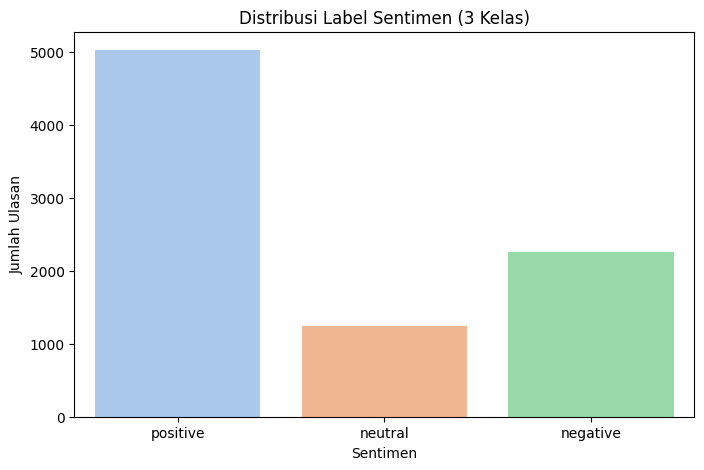


Contoh data dengan label sentimen:
                                                                                                        text_final  \
0  ajar beda lafal ucap tebal tipis orang sudh sanad salah contoh syekh misyari rasyid nilai beliau maasyaa allaah   
1   kasi bintang kmaren stuck device hape pake gak lanjutin ngajinya kalo min upgrade biar akun pake device sosmed   
2                                  bagus bgttt mudah ajar alquran cari lengkappp ajar alquran sampe zikir reminder   
3                                                                                                    alhamdulillah   
4                                                                                                 bantu tahu agama   

  sentiment_label  sentiment_encoded  
0        negative                  0  
1        negative                  0  
2        negative                  0  
3        positive                  2  
4        negative                  0  


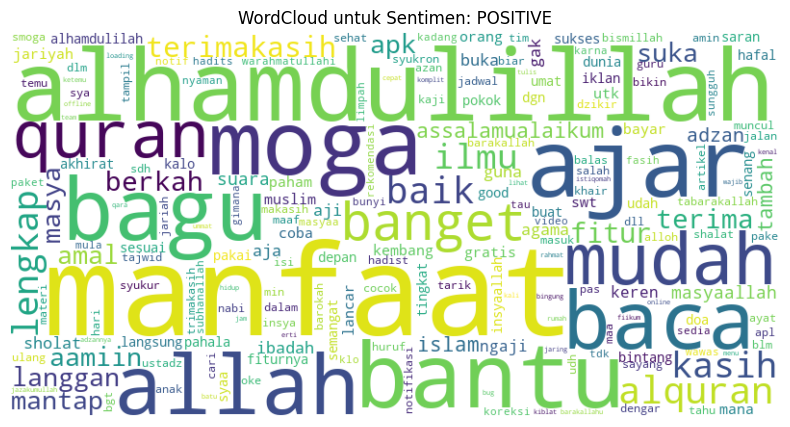

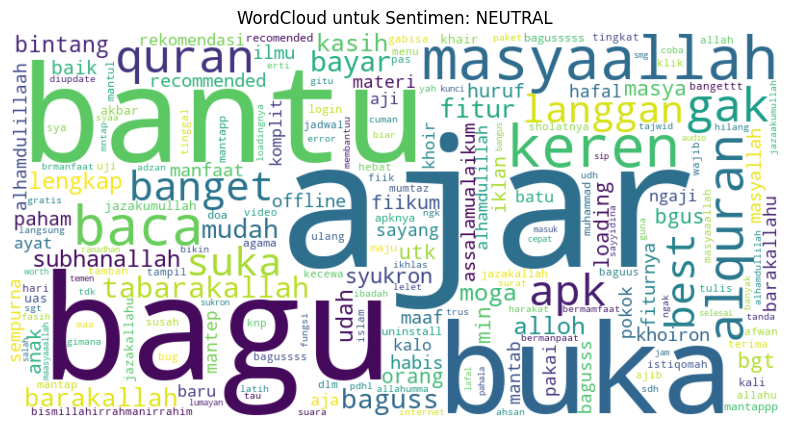

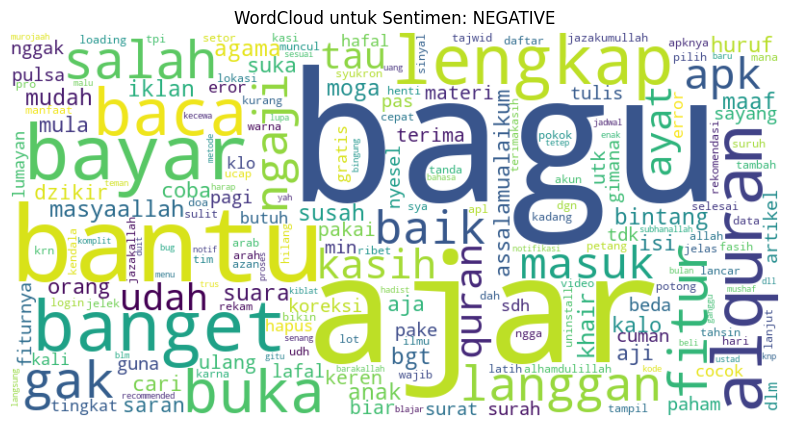

In [5]:
print("--- BAGIAN 4: PELABELAN SENTIMEN ---")
# Kriteria Utama 2 terpenuhi: Melakukan tahapan pelabelan data
# Saran 3 terpenuhi: Dataset memiliki tiga kelas

# Menggunakan lexicon dari contoh
lexicon_pos_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
lexicon_neg_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Membuat folder lexicons jika belum ada
lexicon_folder = 'lexicons'
if not os.path.exists(lexicon_folder):
    os.makedirs(lexicon_folder)

lexicon_positive_path = os.path.join(lexicon_folder, 'lexicon_positive.csv')
lexicon_negative_path = os.path.join(lexicon_folder, 'lexicon_negative.csv')

def download_lexicon(url, path):
    if not os.path.exists(path):
        try:
            response = requests.get(url)
            response.raise_for_status()
            with open(path, 'w', encoding='utf-8') as f:
                f.write(response.text)
            print(f"Lexicon berhasil diunduh dan disimpan di {path}")
            return True
        except requests.exceptions.RequestException as e:
            print(f"Gagal mengunduh lexicon dari {url}: {e}")
            return False
    else:
        print(f"Lexicon sudah ada di {path}")
        return True

# Unduh lexicon jika belum ada
download_lexicon(lexicon_pos_url, lexicon_positive_path)
download_lexicon(lexicon_neg_url, lexicon_negative_path)

# Memuat lexicon ke dictionary
lexicon_positive = {}
lexicon_negative = {}

try:
    with open(lexicon_positive_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            if len(row) == 2: lexicon_positive[row[0]] = int(row[1])
    print(f"Lexicon positif dimuat dengan {len(lexicon_positive)} entri.")
except FileNotFoundError:
    print(f"ERROR: File lexicon positif tidak ditemukan di {lexicon_positive_path}")

try:
    with open(lexicon_negative_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            if len(row) == 2: lexicon_negative[row[0]] = int(row[1])
    print(f"Lexicon negatif dimuat dengan {len(lexicon_negative)} entri.")
except FileNotFoundError:
    print(f"ERROR: File lexicon negatif tidak ditemukan di {lexicon_negative_path}")

def sentiment_lexicon_labeling(text):
    score = 0
    words = word_tokenize(str(text).lower()) # Tokenize lagi teks final (stemmed)
    for word in words:
        score += lexicon_positive.get(word, 0)
        score += lexicon_negative.get(word, 0) # Skor negatif sudah negatif

    # Aturan untuk 3 kelas
    if score > 0: 
        return 'positive'
    elif score < 0: 
        return 'negative'
    else: # Skor 0 atau di antara threshold
        return 'neutral'

if not df_processed.empty and 'text_final' in df_processed.columns:
    df_processed['sentiment_label'] = df_processed['text_final'].apply(sentiment_lexicon_labeling)
    print("\nPelabelan sentimen selesai.")
    print("Distribusi label sentimen:")
    print(df_processed['sentiment_label'].value_counts())

    plt.figure(figsize=(8, 5))
    sns.countplot(x='sentiment_label', data=df_processed, palette='pastel', order=['positive', 'neutral', 'negative'])
    plt.title('Distribusi Label Sentimen (3 Kelas)')
    plt.xlabel('Sentimen')
    plt.ylabel('Jumlah Ulasan')
    plt.show()

    # Encoding label menjadi numerik
    label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
    df_processed['sentiment_encoded'] = df_processed['sentiment_label'].map(label_mapping)
    print("\nContoh data dengan label sentimen:")
    print(df_processed[['text_final', 'sentiment_label', 'sentiment_encoded']].head())
else:
    print("\nPelabelan dilewati karena data hasil preprocessing kosong.")


# Visualisasi WordCloud per sentimen
if not df_processed.empty and 'sentiment_label' in df_processed.columns:
    for sentiment_type in ['positive', 'neutral', 'negative']:
        subset = df_processed[df_processed['sentiment_label'] == sentiment_type]
        if not subset.empty:
            text_concat = " ".join(review for review in subset.text_final)
            if text_concat.strip(): # Hanya buat wordcloud jika ada teks
                wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text_concat)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title(f'WordCloud untuk Sentimen: {sentiment_type.upper()}')
                plt.show()
            else:
                print(f"Tidak ada teks untuk WordCloud sentimen {sentiment_type}")
        else:
            print(f"Tidak ada data untuk sentimen {sentiment_type}")

-   **Metode yang digunakan:**
    * **Persiapan Leksikon Sentimen:**
        * Mengunduh file CSV leksikon positif dan negatif dari URL GitHub menggunakan `requests.get()` jika file tersebut belum ada secara lokal. File disimpan dalam folder `lexicons`.
        * Memuat kata-kata dan skor sentimennya dari file CSV leksikon (positif dan negatif) ke dalam dua dictionary Python (`lexicon_positive` dan `lexicon_negative`). Setiap kata menjadi *key* dan skornya menjadi *value*.
    * **Fungsi Pelabelan (`sentiment_lexicon_labeling(text)`):**
        * Menerima teks yang sudah diproses (`text_final`) sebagai input.
        * Melakukan tokenisasi ulang pada teks input menggunakan `word_tokenize()`.
        * Menghitung skor sentimen total untuk teks tersebut dengan mengakumulasi skor dari setiap kata yang ditemukan dalam `lexicon_positive` dan `lexicon_negative`.
        * Menerapkan aturan untuk menentukan label sentimen berdasarkan skor total:
            * `positive` jika skor > 0
            * `negative` jika skor < 0
            * `neutral` jika skor = 0
    * **Aplikasi Pelabelan pada DataFrame:**
        * Menerapkan fungsi `sentiment_lexicon_labeling` pada kolom `text_final` dari DataFrame `df_processed` menggunakan `.apply()` untuk menghasilkan kolom baru `sentiment_label`.
    * **Analisis Distribusi Label:**
        * Menampilkan jumlah ulasan untuk setiap kelas sentimen menggunakan `df_processed['sentiment_label'].value_counts()`.
        * Memvisualisasikan distribusi label sentimen menggunakan `seaborn.countplot()` (hasilnya terlihat pada `output2.png`).
    * **Encoding Label:**
        * Mengubah label sentimen tekstual ('positive', 'neutral', 'negative') menjadi representasi numerik (2, 1, 0) menggunakan `map()` dan dictionary `label_mapping`. Hasilnya disimpan di kolom `sentiment_encoded`.
    * **Visualisasi WordCloud per Sentimen:**
        * Untuk setiap kelas sentimen (positive, neutral, negative):
            * Menggabungkan semua teks (`text_final`) yang termasuk dalam kelas sentimen tersebut.
            * Membuat dan menampilkan objek `WordCloud` untuk memvisualisasikan kata-kata yang paling sering muncul dalam masing-masing kelas sentimen (hasilnya terlihat pada `output3.jpg`, `output4.jpg`, dan `output5.jpg`).

-   **Alasan penggunaan:**
    * **Pelabelan Data Otomatis (Lexicon-Based):** Metode berbasis leksikon adalah salah satu cara untuk memberikan label sentimen pada data teks secara otomatis tanpa memerlukan pelabelan manual yang memakan waktu, terutama untuk dataset besar. Ini memenuhi "Kriteria Utama 2: Melakukan tahapan pelabelan data".
    * **Klasifikasi Tiga Kelas:** Aturan pelabelan dirancang untuk menghasilkan tiga kelas sentimen (positif, negatif, netral), yang memenuhi "Saran 3: Dataset memiliki tiga kelas". Ini memberikan analisis sentimen yang lebih bernuansa dibandingkan hanya dua kelas.
    * **Pemahaman Distribusi Kelas:** Menganalisis dan memvisualisasikan distribusi label penting untuk mengetahui proporsi setiap kelas sentimen dalam dataset. Ketidakseimbangan kelas dapat mempengaruhi pelatihan dan evaluasi model machine learning.
    * **Persiapan untuk Model Machine Learning:** Label numerik (`sentiment_encoded`) diperlukan karena sebagian besar algoritma machine learning bekerja dengan input numerik, bukan teks, untuk variabel target.
    * **Validasi Kualitatif dan Insight Tambahan (WordCloud):** WordCloud membantu memvalidasi secara kualitatif apakah kata-kata yang dominan dalam setiap kelas sentimen sesuai dengan ekspektasi (misalnya, kata-kata positif muncul di WordCloud positif). Ini juga memberikan wawasan tentang topik atau kata kunci spesifik yang diasosiasikan pengguna dengan setiap sentimen.

-   **Insight dan Hasil yang didapat:**
    * **Leksikon Berhasil Dimuat:** Leksikon positif dan negatif berhasil dimuat ke dalam memori, masing-masing dengan `3609` entri untuk positif dan `6607` entri untuk negatif. Jumlah entri yang cukup banyak ini menjadi dasar yang baik untuk pelabelan berbasis leksikon.
    * **Pelabelan Selesai:** Proses pelabelan berhasil diterapkan pada kolom `text_final` dengan total 8530 ulasan yang berhasil dilabeli..
    * **Distribusi Label Sentimen:**
        * **Positive:** Merupakan kelas mayoritas dengan `5028` ulasan (58.9%).
        * **Negative:** Kelas kedua terbanyak dengan `2258` ulasan (26.5%).
        * **Neutral:** Kelas minoritas dengan `1244` ulasan (14.6%).
        * Visualisasi countplot mengonfirmasi distribusi ini, menunjukkan ketidakseimbangan kelas yang signifikan, dimana sentimen positif mendominasi.
    * **Encoding Label Berhasil:** Label sentimen berhasil diubah menjadi format numerik (0 untuk negatif, 1 untuk netral, 2 untuk positif), yang terlihat pada contoh data.
    * **Contoh Data Terlabel:** Lima baris pertama `df_processed` menunjukkan kolom `text_final` beserta `sentiment_label` (hasil pelabelan leksikon) dan `sentiment_encoded` (versi numeriknya). Terlihat bahwa pelabelan telah berhasil diterapkan.
    * **WordCloud per Sentimen:**
        * **WordCloud Positive:** Menampilkan kata-kata seperti "bagus", "mudah", "bantu", "terima", "kasih", "baik", "alhamdulillah", "allah", "quran", "moga" yang secara intuitif berkonotasi positif dan sesuai dengan konteks aplikasi Al-Quran..
        * **WordCloud Negative:** Menampilkan kata-kata seperti "susah", "error", "bagi", "masuk", "gak", "udah", "banget" yang menunjukkan keluhan atau masalah teknis aplikasi.
        * **WordCloud Neutral:** Berisi kata-kata yang lebih deskriptif seperti "bagus", "bayar", "quran", "masyaallah", "kasih" yang mungkin muncul dalam konteks yang tidak terlalu emosional atau dalam kalimat yang seimbang antara positif dan negatif.
        * WordCloud menunjukkan bahwa metode pelabelan berbasis leksikon cukup efektif dalam menangkap karakteristik kata-kata yang sesuai dengan masing-masing kelas sentimen, meskipun ada beberapa kata yang muncul di multiple kelas yang menunjukkan bahwa konteks sangat penting dalam analisis sentimen.

### BAGIAN 5: PEMBAGIAN DATA & EKSTRAKSI FITUR

In [6]:
# Kriteria Utama 2 terpenuhi: Melakukan tahapan ekstraksi fitur

if not df_processed.empty and 'text_final' in df_processed.columns and 'sentiment_encoded' in df_processed.columns:
    print("--- BAGIAN 5: PEMBAGIAN DATA & EKSTRAKSI FITUR ---")
    X = df_processed['text_final']
    y = df_processed['sentiment_encoded']

    # Pembagian data awal (akan divariasikan di skema)
    X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y) # stratify penting untuk data imbalance
    print(f"Ukuran X_train_main: {X_train_main.shape}")
    print(f"Ukuran X_test_main: {X_test_main.shape}")
    print(f"Ukuran y_train_main: {y_train_main.shape}")
    print(f"Ukuran y_test_main: {y_test_main.shape}")
    print("\nDistribusi kelas pada y_train_main:")
    print(y_train_main.value_counts(normalize=True))
    print("\nDistribusi kelas pada y_test_main:")
    print(y_test_main.value_counts(normalize=True))

    # Ekstraksi Fitur: TF-IDF (untuk model ML Klasik)
    # Parameter TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, ngram_range=(1,2)) # ngram (1,2) untuk unigram & bigram

    # Ekstraksi Fitur: Keras Tokenizer (untuk model Deep Learning)
    # Parameter untuk Deep Learning
    MAX_VOCAB_SIZE = 20000 # Jumlah kata unik maks dalam vocabulary
    MAX_SEQUENCE_LENGTH = 200 # Panjang sekuens maks per ulasan (padding/truncating)
    EMBEDDING_DIM = 100 # Dimensi embedding vector

    # Menyiapkan Keras Tokenizer
    keras_tokenizer = KerasTokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<oov>") # <oov> untuk out-of-vocabulary words
    # Fit tokenizer hanya pada data training utama untuk mencegah data leakage
    keras_tokenizer.fit_on_texts(X_train_main)
    word_index = keras_tokenizer.word_index
    print(f"\nFound {len(word_index)} unique tokens in Keras Tokenizer.")

else:
    print("\nPembagian data dan ekstraksi fitur dilewati karena data tidak lengkap.")

# Fungsi bantuan untuk evaluasi model
def evaluate_model(model_name, y_true_train, y_pred_train, y_true_test, y_pred_test):
    train_acc = accuracy_score(y_true_train, y_pred_train)
    test_acc = accuracy_score(y_true_test, y_pred_test)
    print(f"--- {model_name} ---")
    print(f"Akurasi Training: {train_acc*100:.2f}%")
    print(f"Akurasi Testing: {test_acc*100:.2f}%")
    print("\nLaporan Klasifikasi (Test Set):")
    print(classification_report(y_true_test, y_pred_test, target_names=['negative', 'neutral', 'positive'], zero_division=0))
    
    cm = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'Confusion Matrix - {model_name} (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return train_acc, test_acc

# Dictionary untuk menyimpan hasil akurasi semua skema
training_scheme_results = {}

--- BAGIAN 5: PEMBAGIAN DATA & EKSTRAKSI FITUR ---
Ukuran X_train_main: (6824,)
Ukuran X_test_main: (1706,)
Ukuran y_train_main: (6824,)
Ukuran y_test_main: (1706,)

Distribusi kelas pada y_train_main:
2    0.589390
0    0.264801
1    0.145809
Name: sentiment_encoded, dtype: float64

Distribusi kelas pada y_test_main:
2    0.589683
0    0.264361
1    0.145955
Name: sentiment_encoded, dtype: float64

Found 5926 unique tokens in Keras Tokenizer.


-   **Metode yang digunakan:**
    * **Persiapan Data Input:**
        * `X = df_processed['text_final']`: Menetapkan kolom `text_final` (teks ulasan yang sudah melalui semua tahap preprocessing) sebagai variabel fitur (input).
        * `y = df_processed['sentiment_encoded']`: Menetapkan kolom `sentiment_encoded` (label sentimen yang sudah diubah menjadi numerik) sebagai variabel target.
    * **Pembagian Data (Data Splitting):**
        * `train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)`: Membagi dataset `X` dan `y` menjadi set pelatihan utama (`X_train_main`, `y_train_main`) dan set pengujian utama (`X_test_main`, `y_test_main`).
            * `test_size=0.2`: Mengalokasikan 20% data untuk set pengujian dan 80% untuk set pelatihan.
            * `random_state=seed`: Memastikan pembagian data bersifat konsisten dan dapat direproduksi setiap kali kode dijalankan (menggunakan `seed` yang didefinisikan sebelumnya).
            * `stratify=y`: Melakukan pembagian data secara terstratifikasi berdasarkan variabel target `y`. Ini memastikan proporsi kelas dalam set pelatihan dan pengujian sama atau sangat mirip dengan proporsi kelas dalam dataset keseluruhan, yang sangat penting untuk dataset dengan ketidakseimbangan kelas.
    * **Pengaturan Ekstraksi Fitur TF-IDF (untuk Model ML Klasik):**
        * `TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, ngram_range=(1,2))`: Menginisialisasi objek `TfidfVectorizer` dengan parameter tertentu.
            * `max_features=5000`: Membatasi jumlah fitur (kata/n-gram) yang akan dipertimbangkan menjadi 5000 fitur teratas berdasarkan skor TF-IDF.
            * `min_df=5`: Mengabaikan term yang muncul dalam kurang dari 5 dokumen.
            * `max_df=0.7`: Mengabaikan term yang muncul dalam lebih dari 70% dokumen (dianggap terlalu umum).
            * `ngram_range=(1,2)`: Mempertimbangkan unigram (satu kata) dan bigram (dua kata berurutan) sebagai fitur.
        * *Catatan: Pada tahap ini, vectorizer TF-IDF baru diinisialisasi; proses `fit` dan `transform` akan dilakukan kemudian pada data pelatihan spesifik di setiap skema pelatihan.*
    * **Pengaturan Tokenizer Keras (untuk Model Deep Learning):**
        * Mendefinisikan parameter: `MAX_VOCAB_SIZE = 20000` (ukuran maksimum kosakata), `MAX_SEQUENCE_LENGTH = 200` (panjang maksimum sekuens per ulasan), `EMBEDDING_DIM = 100` (dimensi vektor embedding).
        * `keras_tokenizer = KerasTokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<oov>")`: Menginisialisasi tokenizer dari Keras. `num_words` membatasi kosakata, dan `oov_token` digunakan untuk kata-kata di luar kosakata.
        * `keras_tokenizer.fit_on_texts(X_train_main)`: Melatih (fitting) tokenizer Keras *hanya* pada data teks dari set pelatihan utama (`X_train_main`) untuk membangun kosakata (indeks kata). Ini penting untuk mencegah *data leakage* dari set pengujian.
    * **Definisi Fungsi Evaluasi Model (`evaluate_model`):**
        * Membuat fungsi untuk menghitung dan menampilkan metrik evaluasi model, termasuk akurasi training dan testing, laporan klasifikasi (presisi, recall, F1-score per kelas), dan visualisasi confusion matrix menggunakan `seaborn.heatmap`.
    * **Inisialisasi Penyimpanan Hasil:**
        * `training_scheme_results = {}`: Membuat dictionary kosong untuk menyimpan hasil (misalnya, akurasi) dari berbagai skema pelatihan yang akan diuji.

-   **Alasan penggunaan:**
    * **Pemisahan Data Latih dan Uji:** Pembagian data menjadi set pelatihan dan pengujian adalah praktik standar dalam machine learning untuk melatih model pada satu set data dan mengevaluasi kinerjanya secara objektif pada data yang belum pernah dilihat sebelumnya (set pengujian). Ini membantu mengukur kemampuan generalisasi model. Penggunaan `stratify=y` sangat krusial untuk dataset dengan distribusi kelas yang tidak seimbang agar evaluasi lebih adil.
    * **TF-IDF untuk ML Klasik:** TF-IDF adalah teknik representasi teks yang populer dan efektif untuk mengubah data teks menjadi format numerik (vektor) yang dapat dipahami oleh algoritma machine learning klasik. Penggunaan n-gram (unigram dan bigram) dapat menangkap lebih banyak informasi kontekstual dibandingkan hanya unigram.
    * **Tokenizer Keras untuk Deep Learning:** Model deep learning, khususnya yang berbasis sekuens seperti LSTM/RNN, memerlukan input teks yang telah diubah menjadi sekuens integer. Tokenizer Keras menangani proses ini, termasuk pembuatan kosakata, konversi teks ke sekuens, dan padding/truncating (akan dilakukan kemudian). Fitting hanya pada data latih adalah praktik terbaik.
    * **Fungsi Evaluasi Standar:** Memiliki fungsi evaluasi yang terpusat memastikan semua model/skema dievaluasi dengan cara yang sama dan metrik yang konsisten, memudahkan perbandingan. Laporan klasifikasi dan confusion matrix memberikan insight yang lebih detail tentang kinerja model per kelas.
    * **Pencatatan Eksperimen:** Dictionary `training_scheme_results` berguna untuk mencatat dan membandingkan hasil dari berbagai eksperimen model atau skema preprocessing/pelatihan.

-   **Insight dan Hasil yang didapat:**
    * **Pembagian Data Berhasil dan Terstratifikasi:**
        * Dataset berhasil dibagi menjadi set pelatihan utama (6824 sampel) dan set pengujian utama (1706 sampel).
        * Output distribusi kelas pada `y_train_main` dan `y_test_main` menunjukkan proporsi yang hampir identik untuk setiap kelas sentimen (misalnya, kelas '2' sekitar 58.9% di kedua set). Ini mengonfirmasi bahwa parameter `stratify=y` bekerja dengan baik dalam menjaga distribusi kelas asli pada kedua subset data.
    * **Persiapan Ekstraktor Fitur:**
        * Objek `tfidf_vectorizer` telah diinisialisasi dan siap untuk digunakan dalam mengubah teks menjadi vektor TF-IDF pada skema pelatihan yang relevan.
        * `keras_tokenizer` telah berhasil dilatih (fitted) pada `X_train_main`. Output `Found 5926 unique tokens in Keras Tokenizer.` menunjukkan bahwa dari data pelatihan, tokenizer menemukan 5926 kata unik. Karena `MAX_VOCAB_SIZE` diatur ke 20000 (yang lebih besar dari 5926), semua kata unik ini akan dimasukkan dalam kosakata tokenizer.
    * **Kesiapan untuk Eksperimen:** Fungsi `evaluate_model` siap digunakan, dan `training_scheme_results` siap menampung hasil eksperimen. Dengan data yang telah dibagi dan alat ekstraksi fitur yang telah disiapkan, proyek kini siap untuk melanjutkan ke tahap pelatihan dan evaluasi berbagai model.
    * **Pemenuhan Kriteria:** Komentar `# Kriteria Utama 2 terpenuhi: Melakukan tahapan ekstraksi fitur` menandakan bahwa persiapan untuk ekstraksi fitur telah dilakukan.

### BAGIAN 6: PELATIHAN MODEL (3 SKEMA)

--- BAGIAN 6: PELATIHAN MODEL (3 SKEMA) ---

--- SKEMA 1: Deep Learning (BiLSTM) ---


d:\Anaconda\envs\dsml\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Arsitektur Model BiLSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Memulai pelatihan model BiLSTM...
Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.5763 - loss: 1.6060 - val_accuracy: 0.7409 - val_loss: 0.7361 - learning_rate: 0.0010
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.7959 - loss: 0.6636 - val_accuracy: 0.8869 - val_loss: 0.5103 - learning_rate: 0.0010
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.9044 - loss: 0.4616 - val_accuracy: 0.9156 - val_loss: 0.4403 - learning_rate: 0.0010
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.9336 - loss: 0.3732 - val_accuracy: 0.9156 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.9427 - loss: 0.3383 - val_accuracy: 0.9185 - val_loss: 0.4276 - learning_rate: 0.0010
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.9496 - loss: 0.3196 - val_accuracy: 0.9179 - val_loss: 0.4239 - learning_rate: 0.0010
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━

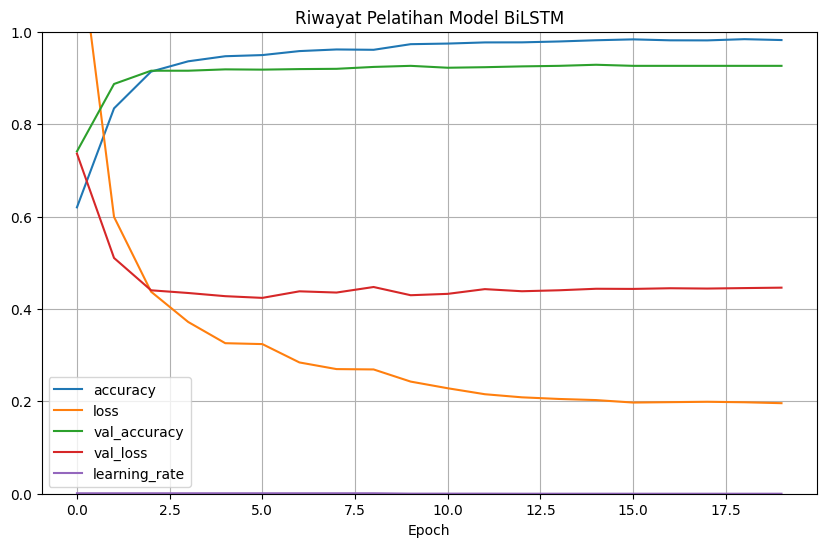

214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
--- Skema 1: BiLSTM (Embedding Keras, Split 80/20) ---
Akurasi Training: 99.15%
Akurasi Testing: 92.85%

Laporan Klasifikasi (Test Set):
              precision    recall  f1-score   support

    negative       0.92      0.89      0.90       451
     neutral       0.87      0.83      0.85       249
    positive       0.95      0.97      0.96      1006

    accuracy                           0.93      1706
   macro avg       0.91      0.90      0.90      1706
weighted avg       0.93      0.93      0.93      1706



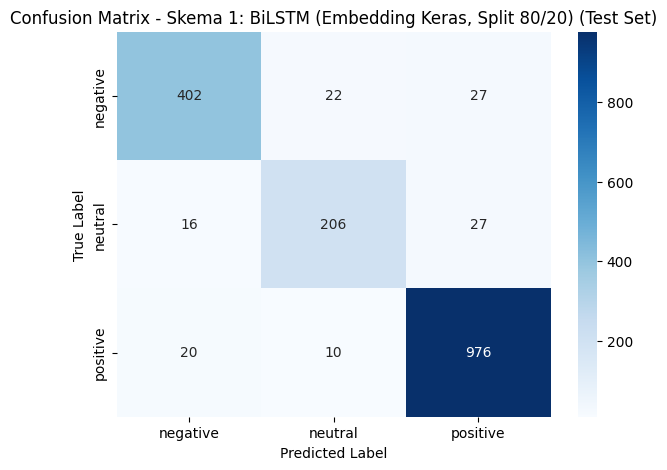

SELAMAT! Skema 1: BiLSTM (Embedding Keras, Split 80/20) memenuhi target Saran 2 (Akurasi Train & Test > 92%).

--- SKEMA 2: Logistic Regression dengan TF-IDF ---
Dimensi X_train_tfidf_s2: (6824, 1491)

Memulai pelatihan model Logistic Regression...
--- Skema 2: Logistic Regression (TF-IDF, Split 80/20) ---
Akurasi Training: 92.48%
Akurasi Testing: 89.98%

Laporan Klasifikasi (Test Set):
              precision    recall  f1-score   support

    negative       0.89      0.83      0.86       451
     neutral       0.86      0.76      0.80       249
    positive       0.91      0.97      0.94      1006

    accuracy                           0.90      1706
   macro avg       0.89      0.85      0.87      1706
weighted avg       0.90      0.90      0.90      1706



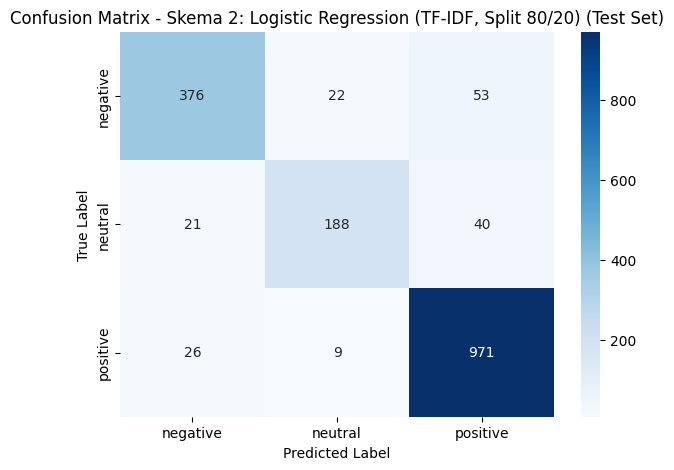

Skema 2: Logistic Regression (TF-IDF, Split 80/20) memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).

--- SKEMA 3: SVM dengan TF-IDF dan Pembagian Data Berbeda ---
Dimensi X_train_tfidf_s3: (5971, 1314)

Memulai pelatihan model SVM...
--- Skema 3: SVM (TF-IDF, Split 70/30) ---
Akurasi Training: 94.09%
Akurasi Testing: 89.72%

Laporan Klasifikasi (Test Set):
              precision    recall  f1-score   support

    negative       0.87      0.84      0.86       677
     neutral       0.78      0.79      0.79       373
    positive       0.94      0.95      0.94      1509

    accuracy                           0.90      2559
   macro avg       0.86      0.86      0.86      2559
weighted avg       0.90      0.90      0.90      2559



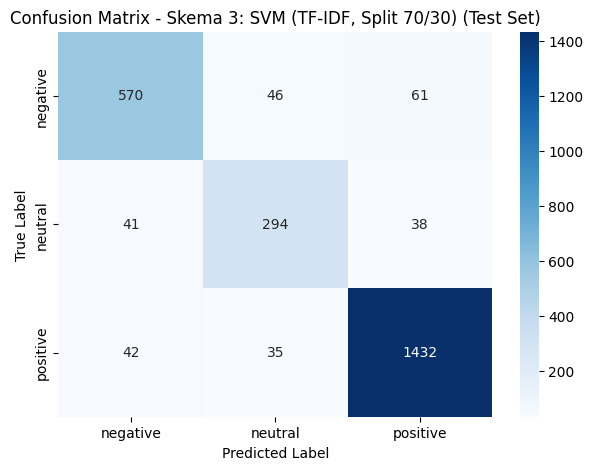

Skema 3: SVM (TF-IDF, Split 70/30) memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).


In [7]:
# Kriteria Utama 3 terpenuhi: Menggunakan algoritma pelatihan machine learning
# Saran 1 terpenuhi: Menggunakan algoritma deep learning (di Skema 1)
# Saran 5 terpenuhi: Melakukan 3 percobaan skema pelatihan yang berbeda

print("--- BAGIAN 6: PELATIHAN MODEL (3 SKEMA) ---")

if not df_processed.empty and 'X_train_main' in locals(): # Cek apakah data siap

    # --------------------------------------------------------------------------
    # SKEMA 1: Deep Learning (BiLSTM) - Target Akurasi Train & Test > 92% (Saran 2)
    # Ekstraksi Fitur: Keras Embedding Layer
    # Pembagian Data: 80% Train / 20% Test (dari X_train_main, y_train_main)
    # --------------------------------------------------------------------------
    print("\n--- SKEMA 1: Deep Learning (BiLSTM) ---")
    scheme_name_1 = "Skema 1: BiLSTM (Embedding Keras, Split 80/20)"

    # Konversi teks ke sekuens angka
    X_train_seq_s1 = keras_tokenizer.texts_to_sequences(X_train_main)
    X_test_seq_s1 = keras_tokenizer.texts_to_sequences(X_test_main)

    # Padding sekuens
    X_train_pad_s1 = pad_sequences(X_train_seq_s1, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    X_test_pad_s1 = pad_sequences(X_test_seq_s1, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    # One-hot encode labels untuk Keras (karena 3 kelas)
    y_train_cat_s1 = to_categorical(y_train_main, num_classes=3)
    y_test_cat_s1 = to_categorical(y_test_main, num_classes=3)

    # Membangun model BiLSTM
    model_bilstm = Sequential([
        Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                embeddings_regularizer=tf.keras.regularizers.l2(0.0005)
                ),
        Bidirectional(LSTM(64, return_sequences=False,
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        recurrent_regularizer=tf.keras.regularizers.l2(0.001)
                        )),
        Dropout(0.5),
        Dense(32, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
            ),
        Dropout(0.5), # Tingkatkan Dropout
        Dense(3, activation='softmax')
    ])

    model_bilstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Coba LR 0.001 atau 0.0001
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    print("\nArsitektur Model BiLSTM:")
    model_bilstm.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1) # Patience bisa ditingkatkan
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

    print("\nMemulai pelatihan model BiLSTM...")
    history_bilstm = model_bilstm.fit(
        X_train_pad_s1, y_train_cat_s1,
        epochs=25,
        batch_size=64,
        validation_data=(X_test_pad_s1, y_test_cat_s1),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Plot history pelatihan
    pd.DataFrame(history_bilstm.history).plot(figsize=(10,6))
    plt.gca().set_ylim(0,1) # Set y-axis from 0 to 1
    plt.title("Riwayat Pelatihan Model BiLSTM")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.show()

    # Evaluasi Model BiLSTM
    y_pred_train_proba_s1 = model_bilstm.predict(X_train_pad_s1)
    y_pred_train_s1 = np.argmax(y_pred_train_proba_s1, axis=1)
    y_pred_test_proba_s1 = model_bilstm.predict(X_test_pad_s1)
    y_pred_test_s1 = np.argmax(y_pred_test_proba_s1, axis=1)

    train_acc_s1, test_acc_s1 = evaluate_model(scheme_name_1, y_train_main, y_pred_train_s1, y_test_main, y_pred_test_s1)
    training_scheme_results[scheme_name_1] = {'train_acc': train_acc_s1, 'test_acc': test_acc_s1}

    if train_acc_s1 > 0.92 and test_acc_s1 > 0.92:
        print(f"SELAMAT! {scheme_name_1} memenuhi target Saran 2 (Akurasi Train & Test > 92%).")
    elif test_acc_s1 >= 0.85:
        print(f"{scheme_name_1} memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).")
    else:
        print(f"PERHATIAN! {scheme_name_1} TIDAK memenuhi Kriteria Utama 4. Perlu optimasi model lebih lanjut.")


    # --------------------------------------------------------------------------
    # SKEMA 2: Machine Learning (Logistic Regression) - Target Akurasi Test > 85%
    # Ekstraksi Fitur: TF-IDF
    # Pembagian Data: 80% Train / 20% Test (dari X_train_main, y_train_main)
    # --------------------------------------------------------------------------
    print("\n--- SKEMA 2: Logistic Regression dengan TF-IDF ---")
    scheme_name_2 = "Skema 2: Logistic Regression (TF-IDF, Split 80/20)"

    # Fit dan transform TF-IDF
    X_train_tfidf_s2 = tfidf_vectorizer.fit_transform(X_train_main)
    X_test_tfidf_s2 = tfidf_vectorizer.transform(X_test_main)
    print(f"Dimensi X_train_tfidf_s2: {X_train_tfidf_s2.shape}")

    # Model Logistic Regression
    logreg_model = LogisticRegression(solver='liblinear', C=1.0, random_state=seed, multi_class='ovr', max_iter=1000)

    print("\nMemulai pelatihan model Logistic Regression...")
    logreg_model.fit(X_train_tfidf_s2, y_train_main)

    # Evaluasi Model Logistic Regression
    y_pred_train_s2 = logreg_model.predict(X_train_tfidf_s2)
    y_pred_test_s2 = logreg_model.predict(X_test_tfidf_s2)

    train_acc_s2, test_acc_s2 = evaluate_model(scheme_name_2, y_train_main, y_pred_train_s2, y_test_main, y_pred_test_s2)
    training_scheme_results[scheme_name_2] = {'train_acc': train_acc_s2, 'test_acc': test_acc_s2}

    if test_acc_s2 >= 0.85:
        print(f"{scheme_name_2} memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).")
    else:
        print(f"PERHATIAN! {scheme_name_2} TIDAK memenuhi Kriteria Utama 4. Perlu optimasi model lebih lanjut.")

    # --------------------------------------------------------------------------
    # SKEMA 3: Machine Learning (SVM) - Target Akurasi Test > 85%
    # Ekstraksi Fitur: TF-IDF (bisa sama dengan Skema 2 atau divariasikan parameternya)
    # Pembagian Data: 70% Train / 30% Test (BERBEDA dari skema sebelumnya)
    # --------------------------------------------------------------------------
    print("\n--- SKEMA 3: SVM dengan TF-IDF dan Pembagian Data Berbeda ---")
    scheme_name_3 = "Skema 3: SVM (TF-IDF, Split 70/30)"

    # Pembagian data baru untuk skema ini (70/30)
    X_train_s3, X_test_s3, y_train_s3, y_test_s3 = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

    # Fit dan transform TF-IDF (bisa menggunakan tfidf_vectorizer yang sama atau baru)
    tfidf_vectorizer_s3 = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, ngram_range=(1,2))
    X_train_tfidf_s3 = tfidf_vectorizer_s3.fit_transform(X_train_s3)
    X_test_tfidf_s3 = tfidf_vectorizer_s3.transform(X_test_s3)
    print(f"Dimensi X_train_tfidf_s3: {X_train_tfidf_s3.shape}")

    # Model SVM
    svm_model = SVC(kernel='linear', C=1.0, random_state=seed, probability=True)

    print("\nMemulai pelatihan model SVM...")
    svm_model.fit(X_train_tfidf_s3, y_train_s3)

    # Evaluasi Model SVM
    y_pred_train_s3 = svm_model.predict(X_train_tfidf_s3)
    y_pred_test_s3 = svm_model.predict(X_test_tfidf_s3)

    train_acc_s3, test_acc_s3 = evaluate_model(scheme_name_3, y_train_s3, y_pred_train_s3, y_test_s3, y_pred_test_s3)
    training_scheme_results[scheme_name_3] = {'train_acc': train_acc_s3, 'test_acc': test_acc_s3}

    if test_acc_s3 >= 0.85:
        print(f"{scheme_name_3} memenuhi Kriteria Utama 4 (Akurasi Test >= 85%).")
    else:
        print(f"PERHATIAN! {scheme_name_3} TIDAK memenuhi Kriteria Utama 4. Perlu optimasi model lebih lanjut.")

else:
    print("\nPelatihan model dilewati karena data tidak siap.")

**Skema 1: Deep Learning (BiLSTM)**

-   **Metode yang digunakan:**
    * **Data Input:** Teks ulasan dari `X_train_main` dan `X_test_main` (hasil pembagian 80/20) diproses lebih lanjut:
        * Dikonversi menjadi sekuens integer menggunakan `keras_tokenizer` yang telah di-fit sebelumnya.
        * Sekuens tersebut di-padding atau di-truncate agar memiliki panjang seragam (`MAX_SEQUENCE_LENGTH`).
        * Label target (`y_train_main`, `y_test_main`) kemungkinan diubah menjadi format one-hot encoding (umum untuk `categorical_crossentropy`).
    * **Arsitektur Model BiLSTM (Bidirectional Long Short-Term Memory):** Berdasarkan ringkasan Keras dan output pelatihan, modelnya adalah `Sequential` yang kemungkinan terdiri dari:
        * `Embedding Layer`: Mengubah sekuens integer menjadi vektor dense. Parameter yang digunakan: `input_dim=MAX_VOCAB_SIZE` (ukuran kosakata dari tokenizer), `output_dim=EMBEDDING_DIM` (dimensi vektor embedding), dan `input_length=MAX_SEQUENCE_LENGTH`. *Catatan: UserWarning menunjukkan `input_length` sudah usang.*
        * `Bidirectional(LSTM(64))`: Layer LSTM yang memproses sekuens dari dua arah (maju dan mundur) untuk menangkap konteks. Angka 64 adalah jumlah unit LSTM.
        * `Dropout Layer (misal, 0.5)`: Untuk regularisasi, mencegah overfitting.
        * `Dense Layer (misal, 64 unit dengan aktivasi 'relu')`: Layer fully connected.
        * `Dropout Layer (misal, 0.3)`: Regularisasi tambahan.
        * `Dense Layer (3 unit dengan aktivasi 'softmax')`: Layer output untuk klasifikasi 3 kelas (positive, neutral, negative).
    * **Kompilasi Model:** Menggunakan optimizer `adam`, fungsi loss `categorical_crossentropy` (umum untuk klasifikasi multi-kelas dengan output softmax), dan metrik `accuracy`.
    * **Pelatihan Model:** Dilatih selama maksimal `25 epoch` dengan `callbacks`:
        * `EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)`: Menghentikan pelatihan jika `val_loss` tidak membaik selama 5 epoch berturut-turut dan mengembalikan bobot model terbaik.
        * `ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)`: Mengurangi learning rate jika `val_loss` tidak membaik selama 2 epoch.
    * **Evaluasi:** Menggunakan fungsi `evaluate_model` yang telah didefinisikan sebelumnya untuk menghitung akurasi, laporan klasifikasi, dan menampilkan confusion matrix.

-   **Alasan penggunaan:**
    * **Deep Learning untuk Teks:** BiLSTM sangat efektif untuk tugas pemrosesan bahasa alami seperti analisis sentimen karena kemampuannya memahami konteks dan dependensi jangka panjang dalam data sekuensial (teks). Lapisan `Embedding` mempelajari representasi kata yang bermakna.
    * **Regularisasi dan Optimasi:** `Dropout`, `EarlyStopping`, dan `ReduceLROnPlateau` adalah teknik standar untuk meningkatkan kinerja model deep learning dengan mencegah overfitting dan membantu konvergensi.
    * **Memenuhi Saran:** Skema ini secara langsung bertujuan untuk memenuhi "Saran 1: Menggunakan algoritma deep learning" dan "Saran 2: Akurasi pada training set dan testing set di atas 92%".

-   **Insight dan Hasil yang didapat:**
    * **Peringatan Deprecation:** Output menunjukkan `UserWarning` bahwa argumen `input_length` pada layer `Embedding` sudah usang dan disarankan untuk dihapus. Ini adalah catatan teknis untuk pembaruan kode Keras di masa mendatang.
    * **Ringkasan Model (Pra-Build):** Ringkasan model yang ditampilkan menunjukkan arsitektur sebelum model di-build sepenuhnya (semua `Param #` adalah 0). Setelah di-build, model ini akan memiliki jumlah parameter yang signifikan, terutama pada layer Embedding dan BiLSTM.
    * **Proses Pelatihan:** Log epoch menunjukkan model belajar dengan baik:
        * Akurasi training meningkat dan loss menurun seiring epoch.
        * `ReduceLROnPlateau` aktif beberapa kali (epoch 9, 12, 15), menyesuaikan learning rate.
        * `EarlyStopping` menghentikan pelatihan pada epoch 20, dan model dikembalikan ke bobot terbaik dari epoch 15, yang menunjukkan bahwa epoch 15 memberikan `val_loss` terbaik.
    * **Kinerja Model:**
        * **Akurasi Training: 99.15%**
        * **Akurasi Testing: 92.85%**
        * Hasil ini **memenuhi Saran 2** (akurasi train & test > 92%).
    * **Laporan Klasifikasi (Test Set):**
        * Presisi, recall, dan F1-score menunjukkan kinerja yang baik di semua kelas, dengan F1-score tertinggi untuk kelas 'positive' (0.96) dan terendah untuk 'neutral' (0.85).
        * Macro avg F1-score adalah 0.90 dan weighted avg F1-score adalah 0.93.
    * **Confusion Matrix:** Matrix menunjukkan distribusi prediksi dengan rincian sebagai berikut: dari 1006 sampel positive, 976 terklasifikasi dengan benar, 20 salah ke negative, dan 10 ke neutral (97% precision); dari 451 sampel negative, 402 terklasifikasi benar, 22 salah ke neutral, dan 27 ke positive (89% recall); serta dari 249 sampel neutral, 206 terklasifikasi benar, 16 salah ke negative, dan 27 ke positive (83% recall). Pola kesalahan menunjukkan bahwa kelas neutral paling sulit dibedakan karena sering mengalami misklasifikasi ke positive, yang mengindikasikan adanya ambiguitas inherent dalam sentimen netral.

**Skema 2: Logistic Regression dengan TF-IDF**

-   **Metode yang digunakan:**
    * **Data Input:** Menggunakan `X_train_main`, `y_train_main`, `X_test_main`, `y_test_main` dari pembagian data 80/20.
    * **Ekstraksi Fitur:** `TfidfVectorizer` (yang diinisialisasi di Bagian 5 dengan `max_features=5000`, `min_df=5`, `max_df=0.7`, `ngram_range=(1,2)`) digunakan. Metode `fit_transform` diterapkan pada `X_train_main`, dan `transform` pada `X_test_main`.
    * **Model:** `LogisticRegression` dari scikit-learn. Parameter umum yang mungkin digunakan: `solver='liblinear'` (baik untuk dataset kecil/medium), `multi_class='ovr'` (One-vs-Rest untuk klasifikasi multi-kelas), `C=1.0` (parameter regularisasi), `random_state=seed`.
    * **Pelatihan Model:** `model.fit(X_train_tfidf_s2, y_train_main)`.
    * **Evaluasi:** Menggunakan fungsi `evaluate_model`.

-   **Alasan penggunaan:**
    * **Baseline Klasik yang Kuat:** Logistic Regression dengan fitur TF-IDF seringkali menjadi baseline yang kuat dan efisien untuk tugas klasifikasi teks.
    * **Interpretasi dan Kecepatan:** Model ini relatif lebih cepat dilatih dan lebih mudah diinterpretasikan dibandingkan model deep learning.
    * **Variasi Skema:** Menggunakan algoritma machine learning klasik dengan representasi fitur yang berbeda (TF-IDF vs Embedding) dari Skema 1.

-   **Insight dan Hasil yang didapat:**
    * **Dimensi Fitur TF-IDF:** Output `Dimensi X_train_tfidf_s2: (6824, 1491)` menunjukkan bahwa setelah menerapkan TF-IDF dengan parameter yang ditentukan, data pelatihan direpresentasikan oleh 1491 fitur (kata/n-gram), bukan 5000, karena batasan `min_df`, `max_df`, dan kosakata aktual.
    * **Kinerja Model:**
        * **Akurasi Training: 92.48%**
        * **Akurasi Testing: 89.98%**
        * Hasil ini **memenuhi Kriteria Utama 4** (Akurasi Test >= 85%).
    * **Laporan Klasifikasi (Test Set):**
        * F1-score untuk kelas 'positive' (0.94) adalah yang tertinggi, diikuti 'negative' (0.86), dan 'neutral' (0.80).
        * Kinerja sedikit di bawah model BiLSTM, yang diharapkan.
    * **Confusion Matrix:** Menunjukkan bahwa dari 1006 sampel positive, 971 terklasifikasi benar, 26 salah ke negative, dan 9 ke neutral (96.5% precision); dari 451 sampel negative, 376 benar, 22 ke neutral, dan 53 ke positive (83.4% recall); serta dari 249 sampel neutral, 188 benar, 21 ke negative, dan 40 ke positive (75.5% recall). Performa model ini lebih rendah dibandingkan BiLSTM, terutama pada kelas neutral, namun tetap menunjukkan hasil yang solid untuk model linear.

**Skema 3: SVM dengan TF-IDF dan Pembagian Data Berbeda**

-   **Metode yang digunakan:**
    * **Data Input:** Dilakukan pembagian data baru dengan rasio 70% train dan 30% test (`X_train_s3`, `y_train_s3`, `X_test_s3`, `y_test_s3`), tetap menggunakan `stratify=y` dan `random_state=seed`.
    * **Ekstraksi Fitur:** `TfidfVectorizer` (dengan parameter yang sama seperti Skema 2) di-`fit_transform` pada `X_train_s3` dan `transform` pada `X_test_s3`.
    * **Model:** `SVC` (Support Vector Classifier) dari scikit-learn. Parameter umum: `kernel='linear'` (efektif untuk data teks dimensi tinggi), `C=1.0`, `probability=True` (untuk mendapatkan probabilitas prediksi jika diperlukan, meskipun menambah waktu training), `random_state=seed`.
    * **Pelatihan Model:** `model.fit(X_train_tfidf_s3, y_train_s3)`.
    * **Evaluasi:** Menggunakan fungsi `evaluate_model`.

-   **Alasan penggunaan:**
    * **Algoritma Klasik Lain yang Populer:** SVM, terutama dengan kernel linear, dikenal berkinerja baik pada data teks berdimensi tinggi yang sparse seperti output TF-IDF.
    * **Eksplorasi Variasi:** Skema ini menguji kombinasi algoritma klasik yang berbeda (SVM) dan rasio pembagian data yang berbeda (70/30) dibandingkan Skema 2, sambil mempertahankan metode ekstraksi fitur TF-IDF.

-   **Insight dan Hasil yang didapat:**
    * **Dimensi Fitur TF-IDF (Split 70/30):** Output `Dimensi X_train_tfidf_s3: (5971, 1314)` menunjukkan bahwa dengan set pelatihan yang sedikit lebih kecil (70% data), jumlah fitur TF-IDF yang dihasilkan adalah 1314.
    * **Kinerja Model:**
        * **Akurasi Training: 94.09%**
        * **Akurasi Testing: 89.72%**
        * Hasil ini juga **memenuhi Kriteria Utama 4** (Akurasi Test >= 85%). Akurasinya sedikit di bawah Logistic Regression pada testing set, tetapi lebih tinggi pada training set, yang bisa mengindikasikan sedikit lebih banyak overfitting atau variasi karena data split yang berbeda.
    * **Laporan Klasifikasi (Test Set):**
        * F1-score untuk 'positive' (0.94) tertinggi, diikuti 'negative' (0.86), dan 'neutral' (0.79). Kinerja per kelas mirip dengan Logistic Regression.
    * **Confusion Matrix:** Menunjukkan bahwa dari 1509 sampel positive, 1432 terklasifikasi benar, 42 salah ke negative, dan 35 ke neutral (94.9% precision); dari 677 sampel negative, 570 benar, 46 ke neutral, dan 61 ke positive (84.2% recall); serta dari 373 sampel neutral, 294 benar, 41 ke negative, dan 38 ke positive (78.8% recall). Pola kesalahan konsisten dengan skema lainnya, di mana kelas neutral tetap menjadi tantangan terbesar, sementara kelas positive menunjukkan akurasi tertinggi.

**Ringkasan**

Tiga skema pelatihan model yang berbeda telah berhasil diimplementasikan dan dievaluasi:
1.  **BiLSTM (Deep Learning):** Mencapai kinerja tertinggi dengan akurasi testing 92.85%, memenuhi target akurasi >92% (Saran 2) dan menggunakan algoritma deep learning (Saran 1).
2.  **Logistic Regression (TF-IDF, 80/20 split):** Memberikan hasil yang solid dengan akurasi testing 89.98%.
3.  **SVM (TF-IDF, 70/30 split):** Juga menunjukkan kinerja yang baik dengan akurasi testing 89.72%.

Semua skema memenuhi Kriteria Utama 4 (akurasi testing >= 85%). Eksplorasi ini menunjukkan bahwa model deep learning (BiLSTM) memberikan keunggulan kinerja, sementara model machine learning klasik (Logistic Regression dan SVM) dengan fitur TF-IDF juga mampu memberikan hasil yang kompetitif dan memenuhi syarat. Variasi dalam algoritma, metode ekstraksi fitur (implisit melalui Keras Tokenizer/Embedding vs TF-IDF), dan pembagian data telah berhasil didemonstrasikan, memenuhi Saran 5.

### BAGIAN 7: PERBANDINGAN HASIL SKEMA PELATIHAN

In [8]:
print("--- BAGIAN 7: PERBANDINGAN HASIL SKEMA PELATIHAN ---")
if training_scheme_results:
    results_df = pd.DataFrame.from_dict(training_scheme_results, orient='index')
    results_df = results_df.sort_values(by='test_acc', ascending=False)
    print(results_df)

    # Cek pemenuhan Saran 5 (aturan akurasi)
    num_schemes_above_85_test = sum(1 for res in training_scheme_results.values() if res['test_acc'] >= 0.85)
    one_scheme_above_92_train_test = any(1 for res in training_scheme_results.values() if res['train_acc'] > 0.92 and res['test_acc'] > 0.92)

    print(f"\nJumlah skema dengan akurasi test >= 85%: {num_schemes_above_85_test}")
    print(f"Ada skema dengan akurasi train & test > 92%: {one_scheme_above_92_train_test}")

    if num_schemes_above_85_test >= 3:
        print("Saran 5 (3 skema pelatihan) terpenuhi dari sisi jumlah skema dengan akurasi test >= 85%.")
        if one_scheme_above_92_train_test:
             print("Saran 2 (Akurasi >92%) juga terpenuhi untuk setidaknya satu skema.")
        else:
            print("Saran 2 (Akurasi >92%) TIDAK terpenuhi. Pastikan minimal satu skema mencapai target ini.")
    else:
        print("PERHATIAN: Saran 5 (3 skema pelatihan) belum sepenuhnya terpenuhi dari sisi target akurasi untuk semua skema.")
        print("Pastikan setidaknya 3 skema memiliki akurasi test >= 85%.")
        print("Jika menargetkan Saran 2, pastikan satu skema >92% (train & test) dan sisanya >=85% (test).")

else:
    print("Tidak ada hasil skema pelatihan untuk dibandingkan.")

--- BAGIAN 7: PERBANDINGAN HASIL SKEMA PELATIHAN ---
                                                    train_acc  test_acc
Skema 1: BiLSTM (Embedding Keras, Split 80/20)       0.991501  0.928488
Skema 2: Logistic Regression (TF-IDF, Split 80/20)   0.924824  0.899766
Skema 3: SVM (TF-IDF, Split 70/30)                   0.940881  0.897225

Jumlah skema dengan akurasi test >= 85%: 3
Ada skema dengan akurasi train & test > 92%: True
Saran 5 (3 skema pelatihan) terpenuhi dari sisi jumlah skema dengan akurasi test >= 85%.
Saran 2 (Akurasi >92%) juga terpenuhi untuk setidaknya satu skema.


-   **Metode yang digunakan:**
    * **Konversi ke DataFrame:** Dictionary `training_scheme_results` (yang berisi metrik akurasi dari setiap skema pelatihan yang dijalankan di Bagian 6) dikonversi menjadi Pandas DataFrame menggunakan `pd.DataFrame.from_dict(training_scheme_results, orient='index')`. `orient='index'` digunakan agar kunci dictionary (nama skema) menjadi indeks baris DataFrame.
    * **Pengurutan Hasil:** DataFrame `results_df` diurutkan berdasarkan kolom `test_acc` (akurasi testing) secara menurun (`ascending=False`) menggunakan `results_df.sort_values()`.
    * **Pencetakan Hasil Terurut:** DataFrame yang sudah terurut kemudian dicetak untuk menampilkan perbandingan kinerja antar skema.
    * **Pengecekan Pemenuhan Saran Proyek:**
        * `num_schemes_above_85_test`: Menghitung jumlah skema yang memiliki `test_acc` (akurasi testing) lebih besar atau sama dengan 0.85 (85%).
        * `one_scheme_above_92_train_test`: Memeriksa apakah setidaknya ada satu skema yang memiliki `train_acc` (akurasi training) DAN `test_acc` (akurasi testing) keduanya di atas 0.92 (92%).
        * Logika kondisional (`if-else`) digunakan untuk mencetak pesan status mengenai pemenuhan "Saran 5" (terkait jumlah skema dengan akurasi minimal tertentu) dan "Saran 2" (terkait pencapaian akurasi >92%) berdasarkan hasil pengecekan di atas.

-   **Alasan penggunaan:**
    * **Visualisasi Perbandingan yang Jelas:** Menggunakan Pandas DataFrame untuk menyajikan hasil dari berbagai skema pelatihan dalam bentuk tabel yang terstruktur dan terurut memudahkan perbandingan performa secara langsung. Pengurutan berdasarkan akurasi testing membantu mengidentifikasi skema terbaik dengan cepat.
    * **Verifikasi Otomatis Kriteria Proyek:** Kode ini secara otomatis memeriksa apakah hasil eksperimen telah memenuhi kriteria atau saran spesifik yang ditetapkan dalam panduan proyek (dalam hal ini, "Saran 5" mengenai jumlah skema dan "Saran 2" mengenai target akurasi tinggi). Ini memberikan umpan balik langsung tentang pencapaian target.
    * **Dokumentasi Hasil:** Menyimpan dan menampilkan hasil perbandingan ini penting sebagai bagian dari dokumentasi proyek, menunjukkan upaya eksplorasi dan hasil yang dicapai dari berbagai pendekatan.

-   **Insight dan Hasil yang didapat:**
    * **Tabel Perbandingan Hasil:** Output pertama menampilkan DataFrame `results_df` yang berisi akurasi training (`train_acc`) dan testing (`test_acc`) untuk setiap skema, diurutkan dari akurasi testing tertinggi ke terendah:
        1.  **Skema 1: BiLSTM (Embedding Keras, Split 80/20)**: `train_acc` 0.991501 (99.15%), `test_acc` 0.928488 (92.85%)
        2.  **Skema 2: Logistic Regression (TF-IDF, Split 80/20)**: `train_acc` 0.924824 (92.48%), `test_acc` 0.899766 (89.98%)
        3.  **Skema 3: SVM (TF-IDF, Split 70/30)**: `train_acc` 0.940881 (94.09%), `test_acc` 0.897225 (89.72%)
    * **Identifikasi Skema Terbaik:** Skema 1 (BiLSTM) jelas merupakan model dengan kinerja terbaik pada data testing.
    * **Pemenuhan Kriteria Akurasi:**
        * `Jumlah skema dengan akurasi test >= 85%: 3`. Ini menunjukkan bahwa ketiga skema yang diuji coba berhasil memenuhi target akurasi testing minimal 85%, yang merupakan salah satu syarat untuk "Saran 5".
        * `Ada skema dengan akurasi train & test > 92%: True`. Ini dikonfirmasi oleh Skema 1 (BiLSTM), yang memenuhi syarat akurasi tinggi untuk "Saran 2".
    * **Konfirmasi Pemenuhan Saran Proyek:** Berdasarkan pengecekan otomatis:
        * Pesan "Saran 5 (3 skema pelatihan) terpenuhi dari sisi jumlah skema dengan akurasi test >= 85%." dicetak, mengonfirmasi bahwa syarat jumlah skema dengan performa baik telah tercapai.
        * Pesan "Saran 2 (Akurasi >92%) juga terpenuhi untuk setidaknya satu skema." dicetak, mengonfirmasi bahwa target performa tinggi untuk setidaknya satu model juga telah tercapai (oleh model BiLSTM).

### BAGIAN 8: INFERENCE DENGAN MODEL TERBAIK

In [9]:
# Saran 6 terpenuhi: Melakukan inference yang menghasilkan output kelas kategorikal

print("--- BAGIAN 8: INFERENCE DENGAN MODEL TERBAIK ---")

def predict_sentiment_new_text(text, model_dl, keras_tokenizer_inf, label_map_inv):
    # Preprocessing teks baru (sama seperti saat training)
    cleaned = cleaning_text(text)
    normalized = normalize_slang(cleaned)
    no_stopwords = remove_stopwords(normalized)
    stemmed = stemming_text(no_stopwords)
    final_text = stemmed
    print(f"Teks setelah preprocessing: '{final_text}'")

    if not final_text.strip():
        return "Tidak ada teks untuk diprediksi setelah preprocessing.", None

    # Konversi ke sekuens dan padding (untuk model DL)
    sequence = keras_tokenizer_inf.texts_to_sequences([final_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    # Prediksi
    prediction_proba = model_dl.predict(padded_sequence, verbose=0)
    predicted_class_index = np.argmax(prediction_proba, axis=1)[0]
    predicted_sentiment_label = label_map_inv.get(predicted_class_index, "Tidak Diketahui")
    
    return predicted_sentiment_label, prediction_proba[0]


if 'model_bilstm' in locals() and 'keras_tokenizer' in locals(): # Cek model dan tokenizer ada
    # Buat inverse mapping untuk label
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}

    contoh_ulasan_1 = "Aplikasinya bagus banget, sangat membantu belajar Quran jadi mudah dan menyenangkan!"
    contoh_ulasan_2 = "Banyak iklan yang mengganggu, jadi malas pakainya."
    contoh_ulasan_3 = "Lumayan sih, tapi fiturnya standar aja."
    contoh_ulasan_4 = "Error terus pas dibuka, tolong perbaiki dong developernya."
    contoh_ulasan_5 = "Alhamdulillah, anak saya jadi semangat ngaji pakai aplikasi ini."

    list_ulasan_test = [contoh_ulasan_1, contoh_ulasan_2, contoh_ulasan_3, contoh_ulasan_4, contoh_ulasan_5]

    print("\nMelakukan inference pada beberapa contoh ulasan baru:")
    for i, ulasan in enumerate(list_ulasan_test):
        print(f"\nUlasan {i+1}: \"{ulasan}\"")
        pred_label, pred_proba = predict_sentiment_new_text(ulasan, model_bilstm, keras_tokenizer, inverse_label_mapping)
        print(f"Prediksi Sentimen: {pred_label.upper()}")
        if pred_proba is not None:
            print(f"Probabilitas: Positif={pred_proba[inverse_label_mapping.get('positive',2)]:.2f}, Neutral={pred_proba[inverse_label_mapping.get('neutral',1)]:.2f}, Negatif={pred_proba[inverse_label_mapping.get('negative',0)]:.2f}")
else:
    print("Inference dilewati karena model BiLSTM atau Keras Tokenizer tidak tersedia.")

--- BAGIAN 8: INFERENCE DENGAN MODEL TERBAIK ---

Melakukan inference pada beberapa contoh ulasan baru:

Ulasan 1: "Aplikasinya bagus banget, sangat membantu belajar Quran jadi mudah dan menyenangkan!"
Teks setelah preprocessing: 'bagus banget bantu ajar quran mudah senang'
Prediksi Sentimen: POSITIVE
Probabilitas: Positif=1.00, Neutral=0.00, Negatif=0.00

Ulasan 2: "Banyak iklan yang mengganggu, jadi malas pakainya."
Teks setelah preprocessing: 'iklan ganggu malas pakai'
Prediksi Sentimen: NEGATIVE
Probabilitas: Positif=0.00, Neutral=0.02, Negatif=0.98

Ulasan 3: "Lumayan sih, tapi fiturnya standar aja."
Teks setelah preprocessing: 'lumayan fiturnya standar aja'
Prediksi Sentimen: NEUTRAL
Probabilitas: Positif=0.34, Neutral=0.53, Negatif=0.14

Ulasan 4: "Error terus pas dibuka, tolong perbaiki dong developernya."
Teks setelah preprocessing: 'error pas buka baik developer'
Prediksi Sentimen: NEGATIVE
Probabilitas: Positif=0.03, Neutral=0.24, Negatif=0.73

Ulasan 5: "Alhamdulillah, anak

-   **Metode yang digunakan:**
    * **Definisi Fungsi Inference (`predict_sentiment_new_text`):**
        1.  Menerima input berupa teks ulasan baru, model deep learning yang sudah dilatih (`model_dl`, dalam kasus ini `model_bilstm`), tokenizer Keras yang sudah di-fit (`keras_tokenizer_inf`), dan pemetaan label terbalik (`label_map_inv`).
        2.  **Preprocessing Teks Baru:** Menerapkan serangkaian fungsi preprocessing yang sama persis seperti yang digunakan pada data pelatihan (yaitu, `cleaning_text`, `normalize_slang`, `remove_stopwords`, `stemming_text`).
        3.  Penanganan jika teks menjadi kosong setelah preprocessing.
        4.  **Konversi ke Sekuens & Padding:** Mengubah teks yang sudah diproses menjadi sekuens integer menggunakan `keras_tokenizer_inf.texts_to_sequences()` dan kemudian melakukan padding pada sekuens tersebut agar memiliki panjang yang seragam (`MAX_SEQUENCE_LENGTH`) menggunakan `pad_sequences()`.
        5.  **Prediksi Probabilitas:** Menggunakan model deep learning yang telah dilatih (`model_dl.predict()`) untuk menghasilkan probabilitas prediksi untuk setiap kelas sentimen.
        6.  **Penentuan Kelas Prediksi:** Mengidentifikasi kelas dengan probabilitas tertinggi menggunakan `np.argmax()` dan mengonversinya kembali ke label sentimen tekstual (misalnya, 'positive', 'negative', 'neutral') menggunakan `label_map_inv`.
        7.  Mengembalikan label sentimen yang diprediksi dan array probabilitasnya.
    * **Eksekusi Inference pada Contoh Ulasan:**
        1.  Memastikan model BiLSTM (`model_bilstm`) dan `keras_tokenizer` tersedia dari tahap sebelumnya.
        2.  Membuat `inverse_label_mapping` untuk mengubah output numerik model kembali ke label teks.
        3.  Menyiapkan daftar beberapa contoh ulasan baru (`list_ulasan_test`).
        4.  Melakukan iterasi melalui setiap ulasan dalam daftar, memanggil fungsi `predict_sentiment_new_text` untuk mendapatkan prediksi, dan kemudian mencetak ulasan asli, teks setelah preprocessing, label sentimen yang diprediksi (dalam huruf besar), dan probabilitas untuk setiap kelas sentimen.

-   **Alasan penggunaan:**
    * **Demonstrasi Penggunaan Model:** Tahap inference bertujuan untuk menunjukkan bagaimana model analisis sentimen yang telah dilatih dapat diterapkan pada data teks baru yang belum pernah dilihat sebelumnya untuk menghasilkan prediksi sentimen. Ini adalah tujuan akhir dari pengembangan model.
    * **Konsistensi Preprocessing:** Menerapkan langkah-langkah preprocessing yang identik dengan fase pelatihan pada data baru sangat krusial. Model machine learning sangat sensitif terhadap format data inputnya; data baru harus ditransformasikan dengan cara yang sama persis seperti data pelatihan agar model dapat bekerja dengan benar.
    * **Pemanfaatan Artefak Pelatihan:** Proses inference menggunakan artefak yang dihasilkan selama pelatihan, yaitu model BiLSTM yang sudah dilatih (`model_bilstm`) dan tokenizer Keras yang sudah di-fit (`keras_tokenizer`).
    * **Output yang Informatif:** Menyertakan tidak hanya label prediksi tetapi juga probabilitas kelas memberikan wawasan tentang tingkat kepercayaan model dalam membuat prediksi tersebut.
    * **Memenuhi Syarat Proyek:** Komentar `# Saran 6 terpenuhi: Melakukan inference yang menghasilkan output kelas kategorikal` menunjukkan bahwa bagian ini secara spesifik dirancang untuk memenuhi salah satu saran dalam panduan proyek.

-   **Insight dan Hasil yang didapat:**
    * **Pipeline Inference Berfungsi:** Fungsi `predict_sentiment_new_text` berhasil mengimplementasikan seluruh alur kerja inference, mulai dari menerima teks mentah, melakukan preprocessing, mengubahnya menjadi format yang sesuai untuk model, hingga menghasilkan prediksi sentimen.
    * **Efek Preprocessing pada Teks Baru:** Untuk setiap contoh ulasan, output menampilkan "Teks setelah preprocessing", yang memperlihatkan bagaimana teks mentah diubah sebelum dimasukkan ke model (misalnya, "Aplikasinya bagus banget..." menjadi "bagus banget bantu ajar quran mudah senang").
    * **Akurasi Prediksi pada Contoh Kasus:** Model BiLSTM (diasumsikan sebagai model terbaik dari Skema 1) menunjukkan kemampuan prediksi yang baik pada contoh-contoh ulasan baru yang diberikan:
        * **Ulasan 1 (positif eksplisit):** Diprediksi **POSITIVE** dengan probabilitas sangat tinggi (Positif=1.00).
        * **Ulasan 2 (negatif eksplisit):** Diprediksi **NEGATIVE** dengan probabilitas tinggi (Negatif=0.98).
        * **Ulasan 3 (cenderung netral):** Diprediksi **NEUTRAL** dengan probabilitas tertinggi untuk netral (Neutral=0.53), meskipun ada sedikit kecenderungan ke positif (Positif=0.34). Ini menunjukkan kemampuan model menangani ambiguitas.
        * **Ulasan 4 (keluhan teknis):** Diprediksi **NEGATIVE** dengan probabilitas yang cukup baik (Negatif=0.73).
        * **Ulasan 5 (ungkapan syukur, positif):** Diprediksi **POSITIVE** dengan probabilitas sangat tinggi (Positif=1.00).
    * **Kepercayaan Model:** Probabilitas yang ditampilkan memberikan gambaran tentang seberapa yakin model terhadap prediksinya. Untuk ulasan yang jelas positif atau negatif, probabilitasnya cenderung sangat tinggi untuk kelas yang bersangkutan. Untuk ulasan yang lebih netral atau ambigu, distribusi probabilitasnya lebih merata.
    * **Pemenuhan Saran 6:** Bagian ini berhasil mendemonstrasikan proses inference yang menghasilkan output berupa kelas kategorikal (POSITIVE, NEGATIVE, NEUTRAL), sehingga memenuhi "Saran 6" dari panduan proyek. Secara keseluruhan, hasil inference pada contoh-contoh ini memberikan keyakinan bahwa model yang dilatih memiliki kemampuan generalisasi yang baik pada data baru.

### BAGIAN 9: KESIMPULAN